In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [58]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [5]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 170795


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [8]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
5,5,322430009006,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,56,56,1,10.0,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,0.648868,2012,1.087793


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [59]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(100, (x.yard_line)), 0)].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [12]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...
[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...
[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...
[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...
[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[8/5670] Updated 5FR Margin for game_id 322440024.
[9/5670] Updating 5FR Margin for game_id 322440127...
[9/5670] Updated 5FR Margin for game_id 322440127.
[10/5670] Updating 5FR Margin for game_id 322442633...
[10/5670] Updated 5FR Margin for game_id 322442633.
[11/5670] Updating 5FR Margin for game_id 322450002...
[11/5670] Updated 5FR Margin for game_id 322450002.
[12/5670] Updating 5FR Margin for game_id 322450005...
[12/5670] Updated 5FR Margin for game_id 322450005.
[13/5670] Updating 5FR Margin for game_id 322450012...
[13/5670] Updated 5FR Margin for game_id 322450012.
[14/5670] Updating 5FR Margin for game_id 322450025...
[14/5670] Updated 5FR Margin for game_id 322450025.
[15/5670] Updating 5FR Margin for game_id 322450030...
[15/5670] Updated 5FR Margin for game_id 322450030.
[16/5670] Updating 5FR Margin for game_id 322450038...
[16/5670] Updated 5FR Margin for game_id 322450038.
[17/5670] Updating 5FR Margin for game_id 322450057...
[17/5670] Updated 5FR Margin for game_id

[85/5670] Updated 5FR Margin for game_id 322522653.
[86/5670] Updating 5FR Margin for game_id 322522751...
[86/5670] Updated 5FR Margin for game_id 322522751.
[87/5670] Updating 5FR Margin for game_id 322570058...
[87/5670] Updated 5FR Margin for game_id 322570058.
[88/5670] Updating 5FR Margin for game_id 322582439...
[88/5670] Updated 5FR Margin for game_id 322582439.
[89/5670] Updating 5FR Margin for game_id 322590002...
[89/5670] Updated 5FR Margin for game_id 322590002.
[90/5670] Updating 5FR Margin for game_id 322590008...
[90/5670] Updated 5FR Margin for game_id 322590008.
[91/5670] Updating 5FR Margin for game_id 322590023...
[91/5670] Updated 5FR Margin for game_id 322590023.
[92/5670] Updating 5FR Margin for game_id 322590024...
[92/5670] Updated 5FR Margin for game_id 322590024.
[93/5670] Updating 5FR Margin for game_id 322590026...
[93/5670] Updated 5FR Margin for game_id 322590026.
[94/5670] Updating 5FR Margin for game_id 322590052...
[94/5670] Updated 5FR Margin for game

[173/5670] Updated 5FR Margin for game_id 322662459.
[174/5670] Updating 5FR Margin for game_id 322662483...
[174/5670] Updated 5FR Margin for game_id 322662483.
[175/5670] Updating 5FR Margin for game_id 322662579...
[175/5670] Updated 5FR Margin for game_id 322662579.
[176/5670] Updating 5FR Margin for game_id 322662628...
[176/5670] Updated 5FR Margin for game_id 322662628.
[177/5670] Updating 5FR Margin for game_id 322662633...
[177/5670] Updated 5FR Margin for game_id 322662633.
[178/5670] Updating 5FR Margin for game_id 322662649...
[178/5670] Updated 5FR Margin for game_id 322662649.
[179/5670] Updating 5FR Margin for game_id 322662711...
[179/5670] Updated 5FR Margin for game_id 322662711.
[180/5670] Updating 5FR Margin for game_id 322710264...
[180/5670] Updated 5FR Margin for game_id 322710264.
[181/5670] Updating 5FR Margin for game_id 322720252...
[181/5670] Updated 5FR Margin for game_id 322720252.
[182/5670] Updating 5FR Margin for game_id 322730005...
[182/5670] Updated 

[253/5670] Updated 5FR Margin for game_id 322800218.
[254/5670] Updating 5FR Margin for game_id 322800228...
[254/5670] Updated 5FR Margin for game_id 322800228.
[255/5670] Updating 5FR Margin for game_id 322800235...
[255/5670] Updated 5FR Margin for game_id 322800235.
[256/5670] Updating 5FR Margin for game_id 322800248...
[256/5670] Updated 5FR Margin for game_id 322800248.
[257/5670] Updating 5FR Margin for game_id 322800251...
[257/5670] Updated 5FR Margin for game_id 322800251.
[258/5670] Updating 5FR Margin for game_id 322800275...
[258/5670] Updated 5FR Margin for game_id 322800275.
[259/5670] Updating 5FR Margin for game_id 322800276...
[259/5670] Updated 5FR Margin for game_id 322800276.
[260/5670] Updating 5FR Margin for game_id 322800309...
[260/5670] Updated 5FR Margin for game_id 322800309.
[261/5670] Updating 5FR Margin for game_id 322800349...
[261/5670] Updated 5FR Margin for game_id 322800349.
[262/5670] Updating 5FR Margin for game_id 322802005...
[262/5670] Updated 

[329/5670] Updated 5FR Margin for game_id 322872641.
[330/5670] Updating 5FR Margin for game_id 322872751...
[330/5670] Updated 5FR Margin for game_id 322872751.
[331/5670] Updating 5FR Margin for game_id 322900249...
[331/5670] Updated 5FR Margin for game_id 322900249.
[332/5670] Updating 5FR Margin for game_id 322920009...
[332/5670] Updated 5FR Margin for game_id 322920009.
[333/5670] Updating 5FR Margin for game_id 322922567...
[333/5670] Updated 5FR Margin for game_id 322922567.
[334/5670] Updating 5FR Margin for game_id 322930183...
[334/5670] Updated 5FR Margin for game_id 322930183.
[335/5670] Updating 5FR Margin for game_id 322940005...
[335/5670] Updated 5FR Margin for game_id 322940005.
[336/5670] Updating 5FR Margin for game_id 322940006...
[336/5670] Updated 5FR Margin for game_id 322940006.
[337/5670] Updating 5FR Margin for game_id 322940012...
[337/5670] Updated 5FR Margin for game_id 322940012.
[338/5670] Updating 5FR Margin for game_id 322940025...
[338/5670] Updated 

[415/5670] Updated 5FR Margin for game_id 323010197.
[416/5670] Updating 5FR Margin for game_id 323010201...
[416/5670] Updated 5FR Margin for game_id 323010201.
[417/5670] Updating 5FR Margin for game_id 323010213...
[417/5670] Updated 5FR Margin for game_id 323010213.
[418/5670] Updating 5FR Margin for game_id 323010221...
[418/5670] Updated 5FR Margin for game_id 323010221.
[419/5670] Updating 5FR Margin for game_id 323010238...
[419/5670] Updated 5FR Margin for game_id 323010238.
[420/5670] Updating 5FR Margin for game_id 323010242...
[420/5670] Updated 5FR Margin for game_id 323010242.
[421/5670] Updating 5FR Margin for game_id 323010248...
[421/5670] Updated 5FR Margin for game_id 323010248.
[422/5670] Updating 5FR Margin for game_id 323010254...
[422/5670] Updated 5FR Margin for game_id 323010254.
[423/5670] Updating 5FR Margin for game_id 323010264...
[423/5670] Updated 5FR Margin for game_id 323010264.
[424/5670] Updating 5FR Margin for game_id 323010275...
[424/5670] Updated 

[498/5670] Updated 5FR Margin for game_id 323082751.
[499/5670] Updating 5FR Margin for game_id 323112649...
[499/5670] Updated 5FR Margin for game_id 323112649.
[500/5670] Updating 5FR Margin for game_id 323120195...
[500/5670] Updated 5FR Margin for game_id 323120195.
[501/5670] Updating 5FR Margin for game_id 323130259...
[501/5670] Updated 5FR Margin for game_id 323130259.
[502/5670] Updating 5FR Margin for game_id 323132032...
[502/5670] Updated 5FR Margin for game_id 323132032.
[503/5670] Updating 5FR Margin for game_id 323140041...
[503/5670] Updated 5FR Margin for game_id 323140041.
[504/5670] Updating 5FR Margin for game_id 323150002...
[504/5670] Updated 5FR Margin for game_id 323150002.
[505/5670] Updating 5FR Margin for game_id 323150005...
[505/5670] Updated 5FR Margin for game_id 323150005.
[506/5670] Updating 5FR Margin for game_id 323150012...
[506/5670] Updated 5FR Margin for game_id 323150012.
[507/5670] Updating 5FR Margin for game_id 323150021...
[507/5670] Updated 

[582/5670] Updated 5FR Margin for game_id 323220238.
[583/5670] Updating 5FR Margin for game_id 323220239...
[583/5670] Updated 5FR Margin for game_id 323220239.
[584/5670] Updating 5FR Margin for game_id 323220242...
[584/5670] Updated 5FR Margin for game_id 323220242.
[585/5670] Updating 5FR Margin for game_id 323220254...
[585/5670] Updated 5FR Margin for game_id 323220254.
[586/5670] Updating 5FR Margin for game_id 323220275...
[586/5670] Updated 5FR Margin for game_id 323220275.
[587/5670] Updating 5FR Margin for game_id 323220276...
[587/5670] Updated 5FR Margin for game_id 323220276.
[588/5670] Updating 5FR Margin for game_id 323220277...
[588/5670] Updated 5FR Margin for game_id 323220277.
[589/5670] Updating 5FR Margin for game_id 323220309...
[589/5670] Updated 5FR Margin for game_id 323220309.
[590/5670] Updating 5FR Margin for game_id 323220344...
[590/5670] Updated 5FR Margin for game_id 323220344.
[591/5670] Updating 5FR Margin for game_id 323220349...
[591/5670] Updated 

[665/5670] Updated 5FR Margin for game_id 323360041.
[666/5670] Updating 5FR Margin for game_id 323360058...
[666/5670] Updated 5FR Margin for game_id 323360058.
[667/5670] Updating 5FR Margin for game_id 323360059...
[667/5670] Updated 5FR Margin for game_id 323360059.
[668/5670] Updating 5FR Margin for game_id 323360061...
[668/5670] Updated 5FR Margin for game_id 323360061.
[669/5670] Updating 5FR Margin for game_id 323360062...
[669/5670] Updated 5FR Margin for game_id 323360062.
[670/5670] Updating 5FR Margin for game_id 323360202...
[670/5670] Updated 5FR Margin for game_id 323360202.
[671/5670] Updating 5FR Margin for game_id 323360239...
[671/5670] Updated 5FR Margin for game_id 323360239.
[672/5670] Updating 5FR Margin for game_id 323360275...
[672/5670] Updated 5FR Margin for game_id 323360275.
[673/5670] Updating 5FR Margin for game_id 323360277...
[673/5670] Updated 5FR Margin for game_id 323360277.
[674/5670] Updating 5FR Margin for game_id 323360326...
[674/5670] Updated 

[744/5670] Updated 5FR Margin for game_id 332500194.
[745/5670] Updating 5FR Margin for game_id 332500195...
[745/5670] Updated 5FR Margin for game_id 332500195.
[746/5670] Updating 5FR Margin for game_id 332500201...
[746/5670] Updated 5FR Margin for game_id 332500201.
[747/5670] Updating 5FR Margin for game_id 332500202...
[747/5670] Updated 5FR Margin for game_id 332500202.
[748/5670] Updating 5FR Margin for game_id 332500204...
[748/5670] Updated 5FR Margin for game_id 332500204.
[749/5670] Updating 5FR Margin for game_id 332500213...
[749/5670] Updated 5FR Margin for game_id 332500213.
[750/5670] Updating 5FR Margin for game_id 332500218...
[750/5670] Updated 5FR Margin for game_id 332500218.
[751/5670] Updating 5FR Margin for game_id 332500235...
[751/5670] Updated 5FR Margin for game_id 332500235.
[752/5670] Updating 5FR Margin for game_id 332500239...
[752/5670] Updated 5FR Margin for game_id 332500239.
[753/5670] Updating 5FR Margin for game_id 332500252...
[753/5670] Updated 

[824/5670] Updated 5FR Margin for game_id 332640113.
[825/5670] Updating 5FR Margin for game_id 332640120...
[825/5670] Updated 5FR Margin for game_id 332640120.
[826/5670] Updating 5FR Margin for game_id 332640135...
[826/5670] Updated 5FR Margin for game_id 332640135.
[827/5670] Updating 5FR Margin for game_id 332640150...
[827/5670] Updated 5FR Margin for game_id 332640150.
[828/5670] Updating 5FR Margin for game_id 332640164...
[828/5670] Updated 5FR Margin for game_id 332640164.
[829/5670] Updating 5FR Margin for game_id 332640183...
[829/5670] Updated 5FR Margin for game_id 332640183.
[830/5670] Updating 5FR Margin for game_id 332640193...
[830/5670] Updated 5FR Margin for game_id 332640193.
[831/5670] Updating 5FR Margin for game_id 332640213...
[831/5670] Updated 5FR Margin for game_id 332640213.
[832/5670] Updating 5FR Margin for game_id 332640235...
[832/5670] Updated 5FR Margin for game_id 332640235.
[833/5670] Updating 5FR Margin for game_id 332640239...
[833/5670] Updated 

[900/5670] Updated 5FR Margin for game_id 332760066.
[901/5670] Updating 5FR Margin for game_id 332760254...
[901/5670] Updated 5FR Margin for game_id 332760254.
[902/5670] Updating 5FR Margin for game_id 332762433...
[902/5670] Updated 5FR Margin for game_id 332762433.
[903/5670] Updating 5FR Margin for game_id 332770021...
[903/5670] Updated 5FR Margin for game_id 332770021.
[904/5670] Updating 5FR Margin for game_id 332770328...
[904/5670] Updated 5FR Margin for game_id 332770328.
[905/5670] Updating 5FR Margin for game_id 332780002...
[905/5670] Updated 5FR Margin for game_id 332780002.
[906/5670] Updating 5FR Margin for game_id 332780005...
[906/5670] Updated 5FR Margin for game_id 332780005.
[907/5670] Updating 5FR Margin for game_id 332780024...
[907/5670] Updated 5FR Margin for game_id 332780024.
[908/5670] Updating 5FR Margin for game_id 332780025...
[908/5670] Updated 5FR Margin for game_id 332780025.
[909/5670] Updating 5FR Margin for game_id 332780038...
[909/5670] Updated 

[978/5670] Updated 5FR Margin for game_id 332850251.
[979/5670] Updating 5FR Margin for game_id 332850252...
[979/5670] Updated 5FR Margin for game_id 332850252.
[980/5670] Updating 5FR Margin for game_id 332850254...
[980/5670] Updated 5FR Margin for game_id 332850254.
[981/5670] Updating 5FR Margin for game_id 332850259...
[981/5670] Updated 5FR Margin for game_id 332850259.
[982/5670] Updating 5FR Margin for game_id 332850264...
[982/5670] Updated 5FR Margin for game_id 332850264.
[983/5670] Updating 5FR Margin for game_id 332850265...
[983/5670] Updated 5FR Margin for game_id 332850265.
[984/5670] Updating 5FR Margin for game_id 332850275...
[984/5670] Updated 5FR Margin for game_id 332850275.
[985/5670] Updating 5FR Margin for game_id 332850326...
[985/5670] Updated 5FR Margin for game_id 332850326.
[986/5670] Updating 5FR Margin for game_id 332850328...
[986/5670] Updated 5FR Margin for game_id 332850328.
[987/5670] Updating 5FR Margin for game_id 332850344...
[987/5670] Updated 

[1064/5670] Updated 5FR Margin for game_id 332990066.
[1065/5670] Updating 5FR Margin for game_id 332990098...
[1065/5670] Updated 5FR Margin for game_id 332990098.
[1066/5670] Updating 5FR Margin for game_id 332990113...
[1066/5670] Updated 5FR Margin for game_id 332990113.
[1067/5670] Updating 5FR Margin for game_id 332990120...
[1067/5670] Updated 5FR Margin for game_id 332990120.
[1068/5670] Updating 5FR Margin for game_id 332990135...
[1068/5670] Updated 5FR Margin for game_id 332990135.
[1069/5670] Updating 5FR Margin for game_id 332990142...
[1069/5670] Updated 5FR Margin for game_id 332990142.
[1070/5670] Updating 5FR Margin for game_id 332990153...
[1070/5670] Updated 5FR Margin for game_id 332990153.
[1071/5670] Updating 5FR Margin for game_id 332990164...
[1071/5670] Updated 5FR Margin for game_id 332990164.
[1072/5670] Updating 5FR Margin for game_id 332990189...
[1072/5670] Updated 5FR Margin for game_id 332990189.
[1073/5670] Updating 5FR Margin for game_id 332990194...
[

[1141/5670] Updated 5FR Margin for game_id 333062226.
[1142/5670] Updating 5FR Margin for game_id 333062229...
[1142/5670] Updated 5FR Margin for game_id 333062229.
[1143/5670] Updating 5FR Margin for game_id 333062247...
[1143/5670] Updated 5FR Margin for game_id 333062247.
[1144/5670] Updating 5FR Margin for game_id 333062294...
[1144/5670] Updated 5FR Margin for game_id 333062294.
[1145/5670] Updating 5FR Margin for game_id 333062306...
[1145/5670] Updated 5FR Margin for game_id 333062306.
[1146/5670] Updating 5FR Margin for game_id 333062439...
[1146/5670] Updated 5FR Margin for game_id 333062439.
[1147/5670] Updating 5FR Margin for game_id 333062509...
[1147/5670] Updated 5FR Margin for game_id 333062509.
[1148/5670] Updating 5FR Margin for game_id 333062579...
[1148/5670] Updated 5FR Margin for game_id 333062579.
[1149/5670] Updating 5FR Margin for game_id 333062628...
[1149/5670] Updated 5FR Margin for game_id 333062628.
[1150/5670] Updating 5FR Margin for game_id 333062641...
[

[1218/5670] Updated 5FR Margin for game_id 333200068.
[1219/5670] Updating 5FR Margin for game_id 333200077...
[1219/5670] Updated 5FR Margin for game_id 333200077.
[1220/5670] Updating 5FR Margin for game_id 333200097...
[1220/5670] Updated 5FR Margin for game_id 333200097.
[1221/5670] Updating 5FR Margin for game_id 333200103...
[1221/5670] Updated 5FR Margin for game_id 333200103.
[1222/5670] Updating 5FR Margin for game_id 333200113...
[1222/5670] Updated 5FR Margin for game_id 333200113.
[1223/5670] Updating 5FR Margin for game_id 333200145...
[1223/5670] Updated 5FR Margin for game_id 333200145.
[1224/5670] Updating 5FR Margin for game_id 333200150...
[1224/5670] Updated 5FR Margin for game_id 333200150.
[1225/5670] Updating 5FR Margin for game_id 333200151...
[1225/5670] Updated 5FR Margin for game_id 333200151.
[1226/5670] Updating 5FR Margin for game_id 333200158...
[1226/5670] Updated 5FR Margin for game_id 333200158.
[1227/5670] Updating 5FR Margin for game_id 333200164...
[

[1293/5670] Updated 5FR Margin for game_id 333272032.
[1294/5670] Updating 5FR Margin for game_id 333272117...
[1294/5670] Updated 5FR Margin for game_id 333272117.
[1295/5670] Updating 5FR Margin for game_id 333272199...
[1295/5670] Updated 5FR Margin for game_id 333272199.
[1296/5670] Updating 5FR Margin for game_id 333272226...
[1296/5670] Updated 5FR Margin for game_id 333272226.
[1297/5670] Updating 5FR Margin for game_id 333272229...
[1297/5670] Updated 5FR Margin for game_id 333272229.
[1298/5670] Updating 5FR Margin for game_id 333272294...
[1298/5670] Updated 5FR Margin for game_id 333272294.
[1299/5670] Updating 5FR Margin for game_id 333272306...
[1299/5670] Updated 5FR Margin for game_id 333272306.
[1300/5670] Updating 5FR Margin for game_id 333272348...
[1300/5670] Updated 5FR Margin for game_id 333272348.
[1301/5670] Updating 5FR Margin for game_id 333272390...
[1301/5670] Updated 5FR Margin for game_id 333272390.
[1302/5670] Updating 5FR Margin for game_id 333272509...
[

[1376/5670] Updated 5FR Margin for game_id 333410239.
[1377/5670] Updating 5FR Margin for game_id 333410242...
[1377/5670] Updated 5FR Margin for game_id 333410242.
[1378/5670] Updating 5FR Margin for game_id 333410278...
[1378/5670] Updated 5FR Margin for game_id 333410278.
[1379/5670] Updating 5FR Margin for game_id 333412567...
[1379/5670] Updated 5FR Margin for game_id 333412567.
[1380/5670] Updating 5FR Margin for game_id 333482426...
[1380/5670] Updated 5FR Margin for game_id 333482426.
[1381/5670] Updating 5FR Margin for game_id 400547640...
[1381/5670] Updated 5FR Margin for game_id 400547640.
[1382/5670] Updating 5FR Margin for game_id 400547641...
[1382/5670] Updated 5FR Margin for game_id 400547641.
[1383/5670] Updating 5FR Margin for game_id 400547642...
[1383/5670] Updated 5FR Margin for game_id 400547642.
[1384/5670] Updating 5FR Margin for game_id 400547644...
[1384/5670] Updated 5FR Margin for game_id 400547644.
[1385/5670] Updating 5FR Margin for game_id 400547647...
[

[1458/5670] Updated 5FR Margin for game_id 400547728.
[1459/5670] Updating 5FR Margin for game_id 400547729...
[1459/5670] Updated 5FR Margin for game_id 400547729.
[1460/5670] Updating 5FR Margin for game_id 400547730...
[1460/5670] Updated 5FR Margin for game_id 400547730.
[1461/5670] Updating 5FR Margin for game_id 400547732...
[1461/5670] Updated 5FR Margin for game_id 400547732.
[1462/5670] Updating 5FR Margin for game_id 400547733...
[1462/5670] Updated 5FR Margin for game_id 400547733.
[1463/5670] Updating 5FR Margin for game_id 400547734...
[1463/5670] Updated 5FR Margin for game_id 400547734.
[1464/5670] Updating 5FR Margin for game_id 400547735...
[1464/5670] Updated 5FR Margin for game_id 400547735.
[1465/5670] Updating 5FR Margin for game_id 400547736...
[1465/5670] Updated 5FR Margin for game_id 400547736.
[1466/5670] Updating 5FR Margin for game_id 400547737...
[1466/5670] Updated 5FR Margin for game_id 400547737.
[1467/5670] Updating 5FR Margin for game_id 400547738...
[

[1538/5670] Updated 5FR Margin for game_id 400547819.
[1539/5670] Updating 5FR Margin for game_id 400547820...
[1539/5670] Updated 5FR Margin for game_id 400547820.
[1540/5670] Updating 5FR Margin for game_id 400547822...
[1540/5670] Updated 5FR Margin for game_id 400547822.
[1541/5670] Updating 5FR Margin for game_id 400547823...
[1541/5670] Updated 5FR Margin for game_id 400547823.
[1542/5670] Updating 5FR Margin for game_id 400547824...
[1542/5670] Updated 5FR Margin for game_id 400547824.
[1543/5670] Updating 5FR Margin for game_id 400547826...
[1543/5670] Updated 5FR Margin for game_id 400547826.
[1544/5670] Updating 5FR Margin for game_id 400547827...
[1544/5670] Updated 5FR Margin for game_id 400547827.
[1545/5670] Updating 5FR Margin for game_id 400547828...
[1545/5670] Updated 5FR Margin for game_id 400547828.
[1546/5670] Updating 5FR Margin for game_id 400547829...
[1546/5670] Updated 5FR Margin for game_id 400547829.
[1547/5670] Updating 5FR Margin for game_id 400547831...
[

[1613/5670] Updated 5FR Margin for game_id 400547907.
[1614/5670] Updating 5FR Margin for game_id 400547908...
[1614/5670] Updated 5FR Margin for game_id 400547908.
[1615/5670] Updating 5FR Margin for game_id 400547909...
[1615/5670] Updated 5FR Margin for game_id 400547909.
[1616/5670] Updating 5FR Margin for game_id 400547910...
[1616/5670] Updated 5FR Margin for game_id 400547910.
[1617/5670] Updating 5FR Margin for game_id 400547911...
[1617/5670] Updated 5FR Margin for game_id 400547911.
[1618/5670] Updating 5FR Margin for game_id 400547912...
[1618/5670] Updated 5FR Margin for game_id 400547912.
[1619/5670] Updating 5FR Margin for game_id 400547913...
[1619/5670] Updated 5FR Margin for game_id 400547913.
[1620/5670] Updating 5FR Margin for game_id 400547914...
[1620/5670] Updated 5FR Margin for game_id 400547914.
[1621/5670] Updating 5FR Margin for game_id 400547915...
[1621/5670] Updated 5FR Margin for game_id 400547915.
[1622/5670] Updating 5FR Margin for game_id 400547917...
[

[1692/5670] Updated 5FR Margin for game_id 400547996.
[1693/5670] Updating 5FR Margin for game_id 400547997...
[1693/5670] Updated 5FR Margin for game_id 400547997.
[1694/5670] Updating 5FR Margin for game_id 400547998...
[1694/5670] Updated 5FR Margin for game_id 400547998.
[1695/5670] Updating 5FR Margin for game_id 400547999...
[1695/5670] Updated 5FR Margin for game_id 400547999.
[1696/5670] Updating 5FR Margin for game_id 400548000...
[1696/5670] Updated 5FR Margin for game_id 400548000.
[1697/5670] Updating 5FR Margin for game_id 400548002...
[1697/5670] Updated 5FR Margin for game_id 400548002.
[1698/5670] Updating 5FR Margin for game_id 400548003...
[1698/5670] Updated 5FR Margin for game_id 400548003.
[1699/5670] Updating 5FR Margin for game_id 400548005...
[1699/5670] Updated 5FR Margin for game_id 400548005.
[1700/5670] Updating 5FR Margin for game_id 400548008...
[1700/5670] Updated 5FR Margin for game_id 400548008.
[1701/5670] Updating 5FR Margin for game_id 400548009...
[

[1776/5670] Updated 5FR Margin for game_id 400548103.
[1777/5670] Updating 5FR Margin for game_id 400548104...
[1777/5670] Updated 5FR Margin for game_id 400548104.
[1778/5670] Updating 5FR Margin for game_id 400548106...
[1778/5670] Updated 5FR Margin for game_id 400548106.
[1779/5670] Updating 5FR Margin for game_id 400548108...
[1779/5670] Updated 5FR Margin for game_id 400548108.
[1780/5670] Updating 5FR Margin for game_id 400548109...
[1780/5670] Updated 5FR Margin for game_id 400548109.
[1781/5670] Updating 5FR Margin for game_id 400548111...
[1781/5670] Updated 5FR Margin for game_id 400548111.
[1782/5670] Updating 5FR Margin for game_id 400548115...
[1782/5670] Updated 5FR Margin for game_id 400548115.
[1783/5670] Updating 5FR Margin for game_id 400548116...
[1783/5670] Updated 5FR Margin for game_id 400548116.
[1784/5670] Updating 5FR Margin for game_id 400548117...
[1784/5670] Updated 5FR Margin for game_id 400548117.
[1785/5670] Updating 5FR Margin for game_id 400548119...
[

[1857/5670] Updated 5FR Margin for game_id 400548205.
[1858/5670] Updating 5FR Margin for game_id 400548206...
[1858/5670] Updated 5FR Margin for game_id 400548206.
[1859/5670] Updating 5FR Margin for game_id 400548207...
[1859/5670] Updated 5FR Margin for game_id 400548207.
[1860/5670] Updating 5FR Margin for game_id 400548208...
[1860/5670] Updated 5FR Margin for game_id 400548208.
[1861/5670] Updating 5FR Margin for game_id 400548209...
[1861/5670] Updated 5FR Margin for game_id 400548209.
[1862/5670] Updating 5FR Margin for game_id 400548210...
[1862/5670] Updated 5FR Margin for game_id 400548210.
[1863/5670] Updating 5FR Margin for game_id 400548211...
[1863/5670] Updated 5FR Margin for game_id 400548211.
[1864/5670] Updating 5FR Margin for game_id 400548212...
[1864/5670] Updated 5FR Margin for game_id 400548212.
[1865/5670] Updating 5FR Margin for game_id 400548213...
[1865/5670] Updated 5FR Margin for game_id 400548213.
[1866/5670] Updating 5FR Margin for game_id 400548214...
[

[1936/5670] Updated 5FR Margin for game_id 400548296.
[1937/5670] Updating 5FR Margin for game_id 400548297...
[1937/5670] Updated 5FR Margin for game_id 400548297.
[1938/5670] Updating 5FR Margin for game_id 400548298...
[1938/5670] Updated 5FR Margin for game_id 400548298.
[1939/5670] Updating 5FR Margin for game_id 400548299...
[1939/5670] Updated 5FR Margin for game_id 400548299.
[1940/5670] Updating 5FR Margin for game_id 400548300...
[1940/5670] Updated 5FR Margin for game_id 400548300.
[1941/5670] Updating 5FR Margin for game_id 400548301...
[1941/5670] Updated 5FR Margin for game_id 400548301.
[1942/5670] Updating 5FR Margin for game_id 400548302...
[1942/5670] Updated 5FR Margin for game_id 400548302.
[1943/5670] Updating 5FR Margin for game_id 400548303...
[1943/5670] Updated 5FR Margin for game_id 400548303.
[1944/5670] Updating 5FR Margin for game_id 400548304...
[1944/5670] Updated 5FR Margin for game_id 400548304.
[1945/5670] Updating 5FR Margin for game_id 400548305...
[

[2021/5670] Updated 5FR Margin for game_id 400548390.
[2022/5670] Updating 5FR Margin for game_id 400548391...
[2022/5670] Updated 5FR Margin for game_id 400548391.
[2023/5670] Updating 5FR Margin for game_id 400548392...
[2023/5670] Updated 5FR Margin for game_id 400548392.
[2024/5670] Updating 5FR Margin for game_id 400548395...
[2024/5670] Updated 5FR Margin for game_id 400548395.
[2025/5670] Updating 5FR Margin for game_id 400548396...
[2025/5670] Updated 5FR Margin for game_id 400548396.
[2026/5670] Updating 5FR Margin for game_id 400548398...
[2026/5670] Updated 5FR Margin for game_id 400548398.
[2027/5670] Updating 5FR Margin for game_id 400548402...
[2027/5670] Updated 5FR Margin for game_id 400548402.
[2028/5670] Updating 5FR Margin for game_id 400548412...
[2028/5670] Updated 5FR Margin for game_id 400548412.
[2029/5670] Updating 5FR Margin for game_id 400548414...
[2029/5670] Updated 5FR Margin for game_id 400548414.
[2030/5670] Updating 5FR Margin for game_id 400548417...
[

[2100/5670] Updated 5FR Margin for game_id 400603865.
[2101/5670] Updating 5FR Margin for game_id 400603866...
[2101/5670] Updated 5FR Margin for game_id 400603866.
[2102/5670] Updating 5FR Margin for game_id 400603867...
[2102/5670] Updated 5FR Margin for game_id 400603867.
[2103/5670] Updating 5FR Margin for game_id 400603868...
[2103/5670] Updated 5FR Margin for game_id 400603868.
[2104/5670] Updating 5FR Margin for game_id 400603869...
[2104/5670] Updated 5FR Margin for game_id 400603869.
[2105/5670] Updating 5FR Margin for game_id 400603870...
[2105/5670] Updated 5FR Margin for game_id 400603870.
[2106/5670] Updating 5FR Margin for game_id 400603872...
[2106/5670] Updated 5FR Margin for game_id 400603872.
[2107/5670] Updating 5FR Margin for game_id 400603873...
[2107/5670] Updated 5FR Margin for game_id 400603873.
[2108/5670] Updating 5FR Margin for game_id 400603874...
[2108/5670] Updated 5FR Margin for game_id 400603874.
[2109/5670] Updating 5FR Margin for game_id 400603875...
[

[2174/5670] Updated 5FR Margin for game_id 400756882.
[2175/5670] Updating 5FR Margin for game_id 400756883...
[2175/5670] Updated 5FR Margin for game_id 400756883.
[2176/5670] Updating 5FR Margin for game_id 400756884...
[2176/5670] Updated 5FR Margin for game_id 400756884.
[2177/5670] Updating 5FR Margin for game_id 400756888...
[2177/5670] Updated 5FR Margin for game_id 400756888.
[2178/5670] Updating 5FR Margin for game_id 400756891...
[2178/5670] Updated 5FR Margin for game_id 400756891.
[2179/5670] Updating 5FR Margin for game_id 400756892...
[2179/5670] Updated 5FR Margin for game_id 400756892.
[2180/5670] Updating 5FR Margin for game_id 400756894...
[2180/5670] Updated 5FR Margin for game_id 400756894.
[2181/5670] Updating 5FR Margin for game_id 400756899...
[2181/5670] Updated 5FR Margin for game_id 400756899.
[2182/5670] Updating 5FR Margin for game_id 400756901...
[2182/5670] Updated 5FR Margin for game_id 400756901.
[2183/5670] Updating 5FR Margin for game_id 400756904...
[

[2264/5670] Updated 5FR Margin for game_id 400756996.
[2265/5670] Updating 5FR Margin for game_id 400756997...
[2265/5670] Updated 5FR Margin for game_id 400756997.
[2266/5670] Updating 5FR Margin for game_id 400756998...
[2266/5670] Updated 5FR Margin for game_id 400756998.
[2267/5670] Updating 5FR Margin for game_id 400757015...
[2267/5670] Updated 5FR Margin for game_id 400757015.
[2268/5670] Updating 5FR Margin for game_id 400757016...
[2268/5670] Updated 5FR Margin for game_id 400757016.
[2269/5670] Updating 5FR Margin for game_id 400757018...
[2269/5670] Updated 5FR Margin for game_id 400757018.
[2270/5670] Updating 5FR Margin for game_id 400757019...
[2270/5670] Updated 5FR Margin for game_id 400757019.
[2271/5670] Updating 5FR Margin for game_id 400757021...
[2271/5670] Updated 5FR Margin for game_id 400757021.
[2272/5670] Updating 5FR Margin for game_id 400757022...
[2272/5670] Updated 5FR Margin for game_id 400757022.
[2273/5670] Updating 5FR Margin for game_id 400757023...
[

[2341/5670] Updated 5FR Margin for game_id 400760496.
[2342/5670] Updating 5FR Margin for game_id 400760497...
[2342/5670] Updated 5FR Margin for game_id 400760497.
[2343/5670] Updating 5FR Margin for game_id 400760498...
[2343/5670] Updated 5FR Margin for game_id 400760498.
[2344/5670] Updating 5FR Margin for game_id 400760499...
[2344/5670] Updated 5FR Margin for game_id 400760499.
[2345/5670] Updating 5FR Margin for game_id 400760500...
[2345/5670] Updated 5FR Margin for game_id 400760500.
[2346/5670] Updating 5FR Margin for game_id 400763398...
[2346/5670] Updated 5FR Margin for game_id 400763398.
[2347/5670] Updating 5FR Margin for game_id 400763399...
[2347/5670] Updated 5FR Margin for game_id 400763399.
[2348/5670] Updating 5FR Margin for game_id 400763403...
[2348/5670] Updated 5FR Margin for game_id 400763403.
[2349/5670] Updating 5FR Margin for game_id 400763404...
[2349/5670] Updated 5FR Margin for game_id 400763404.
[2350/5670] Updating 5FR Margin for game_id 400763407...
[

[2425/5670] Updated 5FR Margin for game_id 400763513.
[2426/5670] Updating 5FR Margin for game_id 400763514...
[2426/5670] Updated 5FR Margin for game_id 400763514.
[2427/5670] Updating 5FR Margin for game_id 400763515...
[2427/5670] Updated 5FR Margin for game_id 400763515.
[2428/5670] Updating 5FR Margin for game_id 400763516...
[2428/5670] Updated 5FR Margin for game_id 400763516.
[2429/5670] Updating 5FR Margin for game_id 400763517...
[2429/5670] Updated 5FR Margin for game_id 400763517.
[2430/5670] Updating 5FR Margin for game_id 400763518...
[2430/5670] Updated 5FR Margin for game_id 400763518.
[2431/5670] Updating 5FR Margin for game_id 400763519...
[2431/5670] Updated 5FR Margin for game_id 400763519.
[2432/5670] Updating 5FR Margin for game_id 400763520...
[2432/5670] Updated 5FR Margin for game_id 400763520.
[2433/5670] Updating 5FR Margin for game_id 400763521...
[2433/5670] Updated 5FR Margin for game_id 400763521.
[2434/5670] Updating 5FR Margin for game_id 400763522...
[

[2503/5670] Updated 5FR Margin for game_id 400763597.
[2504/5670] Updating 5FR Margin for game_id 400763599...
[2504/5670] Updated 5FR Margin for game_id 400763599.
[2505/5670] Updating 5FR Margin for game_id 400763600...
[2505/5670] Updated 5FR Margin for game_id 400763600.
[2506/5670] Updating 5FR Margin for game_id 400763603...
[2506/5670] Updated 5FR Margin for game_id 400763603.
[2507/5670] Updating 5FR Margin for game_id 400763604...
[2507/5670] Updated 5FR Margin for game_id 400763604.
[2508/5670] Updating 5FR Margin for game_id 400763605...
[2508/5670] Updated 5FR Margin for game_id 400763605.
[2509/5670] Updating 5FR Margin for game_id 400763606...
[2509/5670] Updated 5FR Margin for game_id 400763606.
[2510/5670] Updating 5FR Margin for game_id 400763607...
[2510/5670] Updated 5FR Margin for game_id 400763607.
[2511/5670] Updating 5FR Margin for game_id 400763608...
[2511/5670] Updated 5FR Margin for game_id 400763608.
[2512/5670] Updating 5FR Margin for game_id 400763609...
[

[2586/5670] Updated 5FR Margin for game_id 400764885.
[2587/5670] Updating 5FR Margin for game_id 400764886...
[2587/5670] Updated 5FR Margin for game_id 400764886.
[2588/5670] Updating 5FR Margin for game_id 400764887...
[2588/5670] Updated 5FR Margin for game_id 400764887.
[2589/5670] Updating 5FR Margin for game_id 400764888...
[2589/5670] Updated 5FR Margin for game_id 400764888.
[2590/5670] Updating 5FR Margin for game_id 400764889...
[2590/5670] Updated 5FR Margin for game_id 400764889.
[2591/5670] Updating 5FR Margin for game_id 400764890...
[2591/5670] Updated 5FR Margin for game_id 400764890.
[2592/5670] Updating 5FR Margin for game_id 400764891...
[2592/5670] Updated 5FR Margin for game_id 400764891.
[2593/5670] Updating 5FR Margin for game_id 400764892...
[2593/5670] Updated 5FR Margin for game_id 400764892.
[2594/5670] Updating 5FR Margin for game_id 400764893...
[2594/5670] Updated 5FR Margin for game_id 400764893.
[2595/5670] Updating 5FR Margin for game_id 400764894...
[

[2660/5670] Updated 5FR Margin for game_id 400787280.
[2661/5670] Updating 5FR Margin for game_id 400787281...
[2661/5670] Updated 5FR Margin for game_id 400787281.
[2662/5670] Updating 5FR Margin for game_id 400787282...
[2662/5670] Updated 5FR Margin for game_id 400787282.
[2663/5670] Updating 5FR Margin for game_id 400787283...
[2663/5670] Updated 5FR Margin for game_id 400787283.
[2664/5670] Updating 5FR Margin for game_id 400787284...
[2664/5670] Updated 5FR Margin for game_id 400787284.
[2665/5670] Updating 5FR Margin for game_id 400787285...
[2665/5670] Updated 5FR Margin for game_id 400787285.
[2666/5670] Updating 5FR Margin for game_id 400787287...
[2666/5670] Updated 5FR Margin for game_id 400787287.
[2667/5670] Updating 5FR Margin for game_id 400787288...
[2667/5670] Updated 5FR Margin for game_id 400787288.
[2668/5670] Updating 5FR Margin for game_id 400787289...
[2668/5670] Updated 5FR Margin for game_id 400787289.
[2669/5670] Updating 5FR Margin for game_id 400787290...
[

[2734/5670] Updated 5FR Margin for game_id 400787448.
[2735/5670] Updating 5FR Margin for game_id 400787449...
[2735/5670] Updated 5FR Margin for game_id 400787449.
[2736/5670] Updating 5FR Margin for game_id 400787450...
[2736/5670] Updated 5FR Margin for game_id 400787450.
[2737/5670] Updating 5FR Margin for game_id 400787451...
[2737/5670] Updated 5FR Margin for game_id 400787451.
[2738/5670] Updating 5FR Margin for game_id 400787452...
[2738/5670] Updated 5FR Margin for game_id 400787452.
[2739/5670] Updating 5FR Margin for game_id 400787454...
[2739/5670] Updated 5FR Margin for game_id 400787454.
[2740/5670] Updating 5FR Margin for game_id 400787455...
[2740/5670] Updated 5FR Margin for game_id 400787455.
[2741/5670] Updating 5FR Margin for game_id 400787457...
[2741/5670] Updated 5FR Margin for game_id 400787457.
[2742/5670] Updating 5FR Margin for game_id 400787458...
[2742/5670] Updated 5FR Margin for game_id 400787458.
[2743/5670] Updating 5FR Margin for game_id 400787459...
[

[2808/5670] Updated 5FR Margin for game_id 400868923.
[2809/5670] Updating 5FR Margin for game_id 400868924...
[2809/5670] Updated 5FR Margin for game_id 400868924.
[2810/5670] Updating 5FR Margin for game_id 400868925...
[2810/5670] Updated 5FR Margin for game_id 400868925.
[2811/5670] Updating 5FR Margin for game_id 400868926...
[2811/5670] Updated 5FR Margin for game_id 400868926.
[2812/5670] Updating 5FR Margin for game_id 400868927...
[2812/5670] Updated 5FR Margin for game_id 400868927.
[2813/5670] Updating 5FR Margin for game_id 400868928...
[2813/5670] Updated 5FR Margin for game_id 400868928.
[2814/5670] Updating 5FR Margin for game_id 400868930...
[2814/5670] Updated 5FR Margin for game_id 400868930.
[2815/5670] Updating 5FR Margin for game_id 400868932...
[2815/5670] Updated 5FR Margin for game_id 400868932.
[2816/5670] Updating 5FR Margin for game_id 400868933...
[2816/5670] Updated 5FR Margin for game_id 400868933.
[2817/5670] Updating 5FR Margin for game_id 400868946...
[

[2888/5670] Updated 5FR Margin for game_id 400869025.
[2889/5670] Updating 5FR Margin for game_id 400869026...
[2889/5670] Updated 5FR Margin for game_id 400869026.
[2890/5670] Updating 5FR Margin for game_id 400869027...
[2890/5670] Updated 5FR Margin for game_id 400869027.
[2891/5670] Updating 5FR Margin for game_id 400869028...
[2891/5670] Updated 5FR Margin for game_id 400869028.
[2892/5670] Updating 5FR Margin for game_id 400869029...
[2892/5670] Updated 5FR Margin for game_id 400869029.
[2893/5670] Updating 5FR Margin for game_id 400869030...
[2893/5670] Updated 5FR Margin for game_id 400869030.
[2894/5670] Updating 5FR Margin for game_id 400869031...
[2894/5670] Updated 5FR Margin for game_id 400869031.
[2895/5670] Updating 5FR Margin for game_id 400869032...
[2895/5670] Updated 5FR Margin for game_id 400869032.
[2896/5670] Updating 5FR Margin for game_id 400869033...
[2896/5670] Updated 5FR Margin for game_id 400869033.
[2897/5670] Updating 5FR Margin for game_id 400869035...
[

[2965/5670] Updated 5FR Margin for game_id 400869135.
[2966/5670] Updating 5FR Margin for game_id 400869136...
[2966/5670] Updated 5FR Margin for game_id 400869136.
[2967/5670] Updating 5FR Margin for game_id 400869137...
[2967/5670] Updated 5FR Margin for game_id 400869137.
[2968/5670] Updating 5FR Margin for game_id 400869138...
[2968/5670] Updated 5FR Margin for game_id 400869138.
[2969/5670] Updating 5FR Margin for game_id 400869139...
[2969/5670] Updated 5FR Margin for game_id 400869139.
[2970/5670] Updating 5FR Margin for game_id 400869140...
[2970/5670] Updated 5FR Margin for game_id 400869140.
[2971/5670] Updating 5FR Margin for game_id 400869141...
[2971/5670] Updated 5FR Margin for game_id 400869141.
[2972/5670] Updating 5FR Margin for game_id 400869142...
[2972/5670] Updated 5FR Margin for game_id 400869142.
[2973/5670] Updating 5FR Margin for game_id 400869143...
[2973/5670] Updated 5FR Margin for game_id 400869143.
[2974/5670] Updating 5FR Margin for game_id 400869144...
[

[3040/5670] Updated 5FR Margin for game_id 400869223.
[3041/5670] Updating 5FR Margin for game_id 400869224...
[3041/5670] Updated 5FR Margin for game_id 400869224.
[3042/5670] Updating 5FR Margin for game_id 400869225...
[3042/5670] Updated 5FR Margin for game_id 400869225.
[3043/5670] Updating 5FR Margin for game_id 400869226...
[3043/5670] Updated 5FR Margin for game_id 400869226.
[3044/5670] Updating 5FR Margin for game_id 400869227...
[3044/5670] Updated 5FR Margin for game_id 400869227.
[3045/5670] Updating 5FR Margin for game_id 400869228...
[3045/5670] Updated 5FR Margin for game_id 400869228.
[3046/5670] Updating 5FR Margin for game_id 400869230...
[3046/5670] Updated 5FR Margin for game_id 400869230.
[3047/5670] Updating 5FR Margin for game_id 400869231...
[3047/5670] Updated 5FR Margin for game_id 400869231.
[3048/5670] Updating 5FR Margin for game_id 400869232...
[3048/5670] Updated 5FR Margin for game_id 400869232.
[3049/5670] Updating 5FR Margin for game_id 400869233...
[

[3121/5670] Updated 5FR Margin for game_id 400869320.
[3122/5670] Updating 5FR Margin for game_id 400869321...
[3122/5670] Updated 5FR Margin for game_id 400869321.
[3123/5670] Updating 5FR Margin for game_id 400869322...
[3123/5670] Updated 5FR Margin for game_id 400869322.
[3124/5670] Updating 5FR Margin for game_id 400869323...
[3124/5670] Updated 5FR Margin for game_id 400869323.
[3125/5670] Updating 5FR Margin for game_id 400869324...
[3125/5670] Updated 5FR Margin for game_id 400869324.
[3126/5670] Updating 5FR Margin for game_id 400869325...
[3126/5670] Updated 5FR Margin for game_id 400869325.
[3127/5670] Updating 5FR Margin for game_id 400869326...
[3127/5670] Updated 5FR Margin for game_id 400869326.
[3128/5670] Updating 5FR Margin for game_id 400869327...
[3128/5670] Updated 5FR Margin for game_id 400869327.
[3129/5670] Updating 5FR Margin for game_id 400869328...
[3129/5670] Updated 5FR Margin for game_id 400869328.
[3130/5670] Updating 5FR Margin for game_id 400869329...
[

[3207/5670] Updated 5FR Margin for game_id 400869421.
[3208/5670] Updating 5FR Margin for game_id 400869424...
[3208/5670] Updated 5FR Margin for game_id 400869424.
[3209/5670] Updating 5FR Margin for game_id 400869428...
[3209/5670] Updated 5FR Margin for game_id 400869428.
[3210/5670] Updating 5FR Margin for game_id 400869429...
[3210/5670] Updated 5FR Margin for game_id 400869429.
[3211/5670] Updating 5FR Margin for game_id 400869430...
[3211/5670] Updated 5FR Margin for game_id 400869430.
[3212/5670] Updating 5FR Margin for game_id 400869431...
[3212/5670] Updated 5FR Margin for game_id 400869431.
[3213/5670] Updating 5FR Margin for game_id 400869434...
[3213/5670] Updated 5FR Margin for game_id 400869434.
[3214/5670] Updating 5FR Margin for game_id 400869435...
[3214/5670] Updated 5FR Margin for game_id 400869435.
[3215/5670] Updating 5FR Margin for game_id 400869436...
[3215/5670] Updated 5FR Margin for game_id 400869436.
[3216/5670] Updating 5FR Margin for game_id 400869437...
[

[3285/5670] Updated 5FR Margin for game_id 400869522.
[3286/5670] Updating 5FR Margin for game_id 400869524...
[3286/5670] Updated 5FR Margin for game_id 400869524.
[3287/5670] Updating 5FR Margin for game_id 400869525...
[3287/5670] Updated 5FR Margin for game_id 400869525.
[3288/5670] Updating 5FR Margin for game_id 400869526...
[3288/5670] Updated 5FR Margin for game_id 400869526.
[3289/5670] Updating 5FR Margin for game_id 400869527...
[3289/5670] Updated 5FR Margin for game_id 400869527.
[3290/5670] Updating 5FR Margin for game_id 400869528...
[3290/5670] Updated 5FR Margin for game_id 400869528.
[3291/5670] Updating 5FR Margin for game_id 400869529...
[3291/5670] Updated 5FR Margin for game_id 400869529.
[3292/5670] Updating 5FR Margin for game_id 400869530...
[3292/5670] Updated 5FR Margin for game_id 400869530.
[3293/5670] Updating 5FR Margin for game_id 400869531...
[3293/5670] Updated 5FR Margin for game_id 400869531.
[3294/5670] Updating 5FR Margin for game_id 400869533...
[

[3364/5670] Updated 5FR Margin for game_id 400869628.
[3365/5670] Updating 5FR Margin for game_id 400869629...
[3365/5670] Updated 5FR Margin for game_id 400869629.
[3366/5670] Updating 5FR Margin for game_id 400869630...
[3366/5670] Updated 5FR Margin for game_id 400869630.
[3367/5670] Updating 5FR Margin for game_id 400869631...
[3367/5670] Updated 5FR Margin for game_id 400869631.
[3368/5670] Updating 5FR Margin for game_id 400869632...
[3368/5670] Updated 5FR Margin for game_id 400869632.
[3369/5670] Updating 5FR Margin for game_id 400869634...
[3369/5670] Updated 5FR Margin for game_id 400869634.
[3370/5670] Updating 5FR Margin for game_id 400869635...
[3370/5670] Updated 5FR Margin for game_id 400869635.
[3371/5670] Updating 5FR Margin for game_id 400869636...
[3371/5670] Updated 5FR Margin for game_id 400869636.
[3372/5670] Updating 5FR Margin for game_id 400869637...
[3372/5670] Updated 5FR Margin for game_id 400869637.
[3373/5670] Updating 5FR Margin for game_id 400869638...
[

[3441/5670] Updated 5FR Margin for game_id 400869813.
[3442/5670] Updating 5FR Margin for game_id 400869814...
[3442/5670] Updated 5FR Margin for game_id 400869814.
[3443/5670] Updating 5FR Margin for game_id 400869816...
[3443/5670] Updated 5FR Margin for game_id 400869816.
[3444/5670] Updating 5FR Margin for game_id 400869818...
[3444/5670] Updated 5FR Margin for game_id 400869818.
[3445/5670] Updating 5FR Margin for game_id 400869820...
[3445/5670] Updated 5FR Margin for game_id 400869820.
[3446/5670] Updating 5FR Margin for game_id 400869822...
[3446/5670] Updated 5FR Margin for game_id 400869822.
[3447/5670] Updating 5FR Margin for game_id 400869823...
[3447/5670] Updated 5FR Margin for game_id 400869823.
[3448/5670] Updating 5FR Margin for game_id 400869825...
[3448/5670] Updated 5FR Margin for game_id 400869825.
[3449/5670] Updating 5FR Margin for game_id 400869826...
[3449/5670] Updated 5FR Margin for game_id 400869826.
[3450/5670] Updating 5FR Margin for game_id 400869827...
[

[3522/5670] Updated 5FR Margin for game_id 400933875.
[3523/5670] Updating 5FR Margin for game_id 400933876...
[3523/5670] Updated 5FR Margin for game_id 400933876.
[3524/5670] Updating 5FR Margin for game_id 400933877...
[3524/5670] Updated 5FR Margin for game_id 400933877.
[3525/5670] Updating 5FR Margin for game_id 400933878...
[3525/5670] Updated 5FR Margin for game_id 400933878.
[3526/5670] Updating 5FR Margin for game_id 400933879...
[3526/5670] Updated 5FR Margin for game_id 400933879.
[3527/5670] Updating 5FR Margin for game_id 400933880...
[3527/5670] Updated 5FR Margin for game_id 400933880.
[3528/5670] Updating 5FR Margin for game_id 400933881...
[3528/5670] Updated 5FR Margin for game_id 400933881.
[3529/5670] Updating 5FR Margin for game_id 400933882...
[3529/5670] Updated 5FR Margin for game_id 400933882.
[3530/5670] Updating 5FR Margin for game_id 400933883...
[3530/5670] Updated 5FR Margin for game_id 400933883.
[3531/5670] Updating 5FR Margin for game_id 400933884...
[

[3597/5670] Updated 5FR Margin for game_id 400934507.
[3598/5670] Updating 5FR Margin for game_id 400934508...
[3598/5670] Updated 5FR Margin for game_id 400934508.
[3599/5670] Updating 5FR Margin for game_id 400934509...
[3599/5670] Updated 5FR Margin for game_id 400934509.
[3600/5670] Updating 5FR Margin for game_id 400934510...
[3600/5670] Updated 5FR Margin for game_id 400934510.
[3601/5670] Updating 5FR Margin for game_id 400934511...
[3601/5670] Updated 5FR Margin for game_id 400934511.
[3602/5670] Updating 5FR Margin for game_id 400934512...
[3602/5670] Updated 5FR Margin for game_id 400934512.
[3603/5670] Updating 5FR Margin for game_id 400934514...
[3603/5670] Updated 5FR Margin for game_id 400934514.
[3604/5670] Updating 5FR Margin for game_id 400934515...
[3604/5670] Updated 5FR Margin for game_id 400934515.
[3605/5670] Updating 5FR Margin for game_id 400934516...
[3605/5670] Updated 5FR Margin for game_id 400934516.
[3606/5670] Updating 5FR Margin for game_id 400934517...
[

[3671/5670] Updated 5FR Margin for game_id 400934583.
[3672/5670] Updating 5FR Margin for game_id 400935229...
[3672/5670] Updated 5FR Margin for game_id 400935229.
[3673/5670] Updating 5FR Margin for game_id 400935230...
[3673/5670] Updated 5FR Margin for game_id 400935230.
[3674/5670] Updating 5FR Margin for game_id 400935231...
[3674/5670] Updated 5FR Margin for game_id 400935231.
[3675/5670] Updating 5FR Margin for game_id 400935232...
[3675/5670] Updated 5FR Margin for game_id 400935232.
[3676/5670] Updating 5FR Margin for game_id 400935233...
[3676/5670] Updated 5FR Margin for game_id 400935233.
[3677/5670] Updating 5FR Margin for game_id 400935234...
[3677/5670] Updated 5FR Margin for game_id 400935234.
[3678/5670] Updating 5FR Margin for game_id 400935235...
[3678/5670] Updated 5FR Margin for game_id 400935235.
[3679/5670] Updating 5FR Margin for game_id 400935236...
[3679/5670] Updated 5FR Margin for game_id 400935236.
[3680/5670] Updating 5FR Margin for game_id 400935237...
[

[3757/5670] Updated 5FR Margin for game_id 400935324.
[3758/5670] Updating 5FR Margin for game_id 400935325...
[3758/5670] Updated 5FR Margin for game_id 400935325.
[3759/5670] Updating 5FR Margin for game_id 400935326...
[3759/5670] Updated 5FR Margin for game_id 400935326.
[3760/5670] Updating 5FR Margin for game_id 400935327...
[3760/5670] Updated 5FR Margin for game_id 400935327.
[3761/5670] Updating 5FR Margin for game_id 400935328...
[3761/5670] Updated 5FR Margin for game_id 400935328.
[3762/5670] Updating 5FR Margin for game_id 400935329...
[3762/5670] Updated 5FR Margin for game_id 400935329.
[3763/5670] Updating 5FR Margin for game_id 400935330...
[3763/5670] Updated 5FR Margin for game_id 400935330.
[3764/5670] Updating 5FR Margin for game_id 400935347...
[3764/5670] Updated 5FR Margin for game_id 400935347.
[3765/5670] Updating 5FR Margin for game_id 400935348...
[3765/5670] Updated 5FR Margin for game_id 400935348.
[3766/5670] Updating 5FR Margin for game_id 400935349...
[

[3840/5670] Updated 5FR Margin for game_id 400937453.
[3841/5670] Updating 5FR Margin for game_id 400937456...
[3841/5670] Updated 5FR Margin for game_id 400937456.
[3842/5670] Updating 5FR Margin for game_id 400937458...
[3842/5670] Updated 5FR Margin for game_id 400937458.
[3843/5670] Updating 5FR Margin for game_id 400937459...
[3843/5670] Updated 5FR Margin for game_id 400937459.
[3844/5670] Updating 5FR Margin for game_id 400937461...
[3844/5670] Updated 5FR Margin for game_id 400937461.
[3845/5670] Updating 5FR Margin for game_id 400937464...
[3845/5670] Updated 5FR Margin for game_id 400937464.
[3846/5670] Updating 5FR Margin for game_id 400937466...
[3846/5670] Updated 5FR Margin for game_id 400937466.
[3847/5670] Updating 5FR Margin for game_id 400937467...
[3847/5670] Updated 5FR Margin for game_id 400937467.
[3848/5670] Updating 5FR Margin for game_id 400937468...
[3848/5670] Updated 5FR Margin for game_id 400937468.
[3849/5670] Updating 5FR Margin for game_id 400937469...
[

[3918/5670] Updated 5FR Margin for game_id 400938611.
[3919/5670] Updating 5FR Margin for game_id 400938612...
[3919/5670] Updated 5FR Margin for game_id 400938612.
[3920/5670] Updating 5FR Margin for game_id 400938614...
[3920/5670] Updated 5FR Margin for game_id 400938614.
[3921/5670] Updating 5FR Margin for game_id 400938615...
[3921/5670] Updated 5FR Margin for game_id 400938615.
[3922/5670] Updating 5FR Margin for game_id 400938616...
[3922/5670] Updated 5FR Margin for game_id 400938616.
[3923/5670] Updating 5FR Margin for game_id 400938617...
[3923/5670] Updated 5FR Margin for game_id 400938617.
[3924/5670] Updating 5FR Margin for game_id 400938618...
[3924/5670] Updated 5FR Margin for game_id 400938618.
[3925/5670] Updating 5FR Margin for game_id 400938619...
[3925/5670] Updated 5FR Margin for game_id 400938619.
[3926/5670] Updating 5FR Margin for game_id 400938620...
[3926/5670] Updated 5FR Margin for game_id 400938620.
[3927/5670] Updating 5FR Margin for game_id 400938621...
[

[4002/5670] Updated 5FR Margin for game_id 400941811.
[4003/5670] Updating 5FR Margin for game_id 400941813...
[4003/5670] Updated 5FR Margin for game_id 400941813.
[4004/5670] Updating 5FR Margin for game_id 400941814...
[4004/5670] Updated 5FR Margin for game_id 400941814.
[4005/5670] Updating 5FR Margin for game_id 400941815...
[4005/5670] Updated 5FR Margin for game_id 400941815.
[4006/5670] Updating 5FR Margin for game_id 400941816...
[4006/5670] Updated 5FR Margin for game_id 400941816.
[4007/5670] Updating 5FR Margin for game_id 400941817...
[4007/5670] Updated 5FR Margin for game_id 400941817.
[4008/5670] Updating 5FR Margin for game_id 400941818...
[4008/5670] Updated 5FR Margin for game_id 400941818.
[4009/5670] Updating 5FR Margin for game_id 400941819...
[4009/5670] Updated 5FR Margin for game_id 400941819.
[4010/5670] Updating 5FR Margin for game_id 400941820...
[4010/5670] Updated 5FR Margin for game_id 400941820.
[4011/5670] Updating 5FR Margin for game_id 400941821...
[

[4076/5670] Updated 5FR Margin for game_id 400944875.
[4077/5670] Updating 5FR Margin for game_id 400944877...
[4077/5670] Updated 5FR Margin for game_id 400944877.
[4078/5670] Updating 5FR Margin for game_id 400944878...
[4078/5670] Updated 5FR Margin for game_id 400944878.
[4079/5670] Updating 5FR Margin for game_id 400944879...
[4079/5670] Updated 5FR Margin for game_id 400944879.
[4080/5670] Updating 5FR Margin for game_id 400944880...
[4080/5670] Updated 5FR Margin for game_id 400944880.
[4081/5670] Updating 5FR Margin for game_id 400944881...
[4081/5670] Updated 5FR Margin for game_id 400944881.
[4082/5670] Updating 5FR Margin for game_id 400944883...
[4082/5670] Updated 5FR Margin for game_id 400944883.
[4083/5670] Updating 5FR Margin for game_id 400944884...
[4083/5670] Updated 5FR Margin for game_id 400944884.
[4084/5670] Updating 5FR Margin for game_id 400944885...
[4084/5670] Updated 5FR Margin for game_id 400944885.
[4085/5670] Updating 5FR Margin for game_id 400944886...
[

[4160/5670] Updated 5FR Margin for game_id 400945279.
[4161/5670] Updating 5FR Margin for game_id 400945280...
[4161/5670] Updated 5FR Margin for game_id 400945280.
[4162/5670] Updating 5FR Margin for game_id 400945281...
[4162/5670] Updated 5FR Margin for game_id 400945281.
[4163/5670] Updating 5FR Margin for game_id 400945282...
[4163/5670] Updated 5FR Margin for game_id 400945282.
[4164/5670] Updating 5FR Margin for game_id 400945283...
[4164/5670] Updated 5FR Margin for game_id 400945283.
[4165/5670] Updating 5FR Margin for game_id 400945284...
[4165/5670] Updated 5FR Margin for game_id 400945284.
[4166/5670] Updating 5FR Margin for game_id 400945285...
[4166/5670] Updated 5FR Margin for game_id 400945285.
[4167/5670] Updating 5FR Margin for game_id 400945286...
[4167/5670] Updated 5FR Margin for game_id 400945286.
[4168/5670] Updating 5FR Margin for game_id 400945287...
[4168/5670] Updated 5FR Margin for game_id 400945287.
[4169/5670] Updating 5FR Margin for game_id 400945288...
[

[4236/5670] Updated 5FR Margin for game_id 401012287.
[4237/5670] Updating 5FR Margin for game_id 401012288...
[4237/5670] Updated 5FR Margin for game_id 401012288.
[4238/5670] Updating 5FR Margin for game_id 401012289...
[4238/5670] Updated 5FR Margin for game_id 401012289.
[4239/5670] Updating 5FR Margin for game_id 401012290...
[4239/5670] Updated 5FR Margin for game_id 401012290.
[4240/5670] Updating 5FR Margin for game_id 401012291...
[4240/5670] Updated 5FR Margin for game_id 401012291.
[4241/5670] Updating 5FR Margin for game_id 401012292...
[4241/5670] Updated 5FR Margin for game_id 401012292.
[4242/5670] Updating 5FR Margin for game_id 401012293...
[4242/5670] Updated 5FR Margin for game_id 401012293.
[4243/5670] Updating 5FR Margin for game_id 401012294...
[4243/5670] Updated 5FR Margin for game_id 401012294.
[4244/5670] Updating 5FR Margin for game_id 401012295...
[4244/5670] Updated 5FR Margin for game_id 401012295.
[4245/5670] Updating 5FR Margin for game_id 401012296...
[

[4318/5670] Updated 5FR Margin for game_id 401012735.
[4319/5670] Updating 5FR Margin for game_id 401012736...
[4319/5670] Updated 5FR Margin for game_id 401012736.
[4320/5670] Updating 5FR Margin for game_id 401012738...
[4320/5670] Updated 5FR Margin for game_id 401012738.
[4321/5670] Updating 5FR Margin for game_id 401012739...
[4321/5670] Updated 5FR Margin for game_id 401012739.
[4322/5670] Updating 5FR Margin for game_id 401012740...
[4322/5670] Updated 5FR Margin for game_id 401012740.
[4323/5670] Updating 5FR Margin for game_id 401012742...
[4323/5670] Updated 5FR Margin for game_id 401012742.
[4324/5670] Updating 5FR Margin for game_id 401012743...
[4324/5670] Updated 5FR Margin for game_id 401012743.
[4325/5670] Updating 5FR Margin for game_id 401012744...
[4325/5670] Updated 5FR Margin for game_id 401012744.
[4326/5670] Updating 5FR Margin for game_id 401012748...
[4326/5670] Updated 5FR Margin for game_id 401012748.
[4327/5670] Updating 5FR Margin for game_id 401012749...
[

[4404/5670] Updated 5FR Margin for game_id 401012852.
[4405/5670] Updating 5FR Margin for game_id 401012853...
[4405/5670] Updated 5FR Margin for game_id 401012853.
[4406/5670] Updating 5FR Margin for game_id 401012854...
[4406/5670] Updated 5FR Margin for game_id 401012854.
[4407/5670] Updating 5FR Margin for game_id 401012855...
[4407/5670] Updated 5FR Margin for game_id 401012855.
[4408/5670] Updating 5FR Margin for game_id 401012856...
[4408/5670] Updated 5FR Margin for game_id 401012856.
[4409/5670] Updating 5FR Margin for game_id 401012857...
[4409/5670] Updated 5FR Margin for game_id 401012857.
[4410/5670] Updating 5FR Margin for game_id 401012858...
[4410/5670] Updated 5FR Margin for game_id 401012858.
[4411/5670] Updating 5FR Margin for game_id 401012859...
[4411/5670] Updated 5FR Margin for game_id 401012859.
[4412/5670] Updating 5FR Margin for game_id 401012860...
[4412/5670] Updated 5FR Margin for game_id 401012860.
[4413/5670] Updating 5FR Margin for game_id 401012861...
[

[4484/5670] Updated 5FR Margin for game_id 401013067.
[4485/5670] Updating 5FR Margin for game_id 401013068...
[4485/5670] Updated 5FR Margin for game_id 401013068.
[4486/5670] Updating 5FR Margin for game_id 401013069...
[4486/5670] Updated 5FR Margin for game_id 401013069.
[4487/5670] Updating 5FR Margin for game_id 401013070...
[4487/5670] Updated 5FR Margin for game_id 401013070.
[4488/5670] Updating 5FR Margin for game_id 401013071...
[4488/5670] Updated 5FR Margin for game_id 401013071.
[4489/5670] Updating 5FR Margin for game_id 401013074...
[4489/5670] Updated 5FR Margin for game_id 401013074.
[4490/5670] Updating 5FR Margin for game_id 401013075...
[4490/5670] Updated 5FR Margin for game_id 401013075.
[4491/5670] Updating 5FR Margin for game_id 401013076...
[4491/5670] Updated 5FR Margin for game_id 401013076.
[4492/5670] Updating 5FR Margin for game_id 401013077...
[4492/5670] Updated 5FR Margin for game_id 401013077.
[4493/5670] Updating 5FR Margin for game_id 401013078...
[

[4558/5670] Updated 5FR Margin for game_id 401013167.
[4559/5670] Updating 5FR Margin for game_id 401013168...
[4559/5670] Updated 5FR Margin for game_id 401013168.
[4560/5670] Updating 5FR Margin for game_id 401013169...
[4560/5670] Updated 5FR Margin for game_id 401013169.
[4561/5670] Updating 5FR Margin for game_id 401013170...
[4561/5670] Updated 5FR Margin for game_id 401013170.
[4562/5670] Updating 5FR Margin for game_id 401013171...
[4562/5670] Updated 5FR Margin for game_id 401013171.
[4563/5670] Updating 5FR Margin for game_id 401013172...
[4563/5670] Updated 5FR Margin for game_id 401013172.
[4564/5670] Updating 5FR Margin for game_id 401013173...
[4564/5670] Updated 5FR Margin for game_id 401013173.
[4565/5670] Updating 5FR Margin for game_id 401013174...
[4565/5670] Updated 5FR Margin for game_id 401013174.
[4566/5670] Updating 5FR Margin for game_id 401013175...
[4566/5670] Updated 5FR Margin for game_id 401013175.
[4567/5670] Updating 5FR Margin for game_id 401013176...
[

[4639/5670] Updated 5FR Margin for game_id 401013443.
[4640/5670] Updating 5FR Margin for game_id 401013444...
[4640/5670] Updated 5FR Margin for game_id 401013444.
[4641/5670] Updating 5FR Margin for game_id 401013446...
[4641/5670] Updated 5FR Margin for game_id 401013446.
[4642/5670] Updating 5FR Margin for game_id 401013447...
[4642/5670] Updated 5FR Margin for game_id 401013447.
[4643/5670] Updating 5FR Margin for game_id 401013448...
[4643/5670] Updated 5FR Margin for game_id 401013448.
[4644/5670] Updating 5FR Margin for game_id 401013450...
[4644/5670] Updated 5FR Margin for game_id 401013450.
[4645/5670] Updating 5FR Margin for game_id 401013451...
[4645/5670] Updated 5FR Margin for game_id 401013451.
[4646/5670] Updating 5FR Margin for game_id 401013452...
[4646/5670] Updated 5FR Margin for game_id 401013452.
[4647/5670] Updating 5FR Margin for game_id 401013466...
[4647/5670] Updated 5FR Margin for game_id 401013466.
[4648/5670] Updating 5FR Margin for game_id 401013490...
[

[4714/5670] Updated 5FR Margin for game_id 401015052.
[4715/5670] Updating 5FR Margin for game_id 401015053...
[4715/5670] Updated 5FR Margin for game_id 401015053.
[4716/5670] Updating 5FR Margin for game_id 401015054...
[4716/5670] Updated 5FR Margin for game_id 401015054.
[4717/5670] Updating 5FR Margin for game_id 401015055...
[4717/5670] Updated 5FR Margin for game_id 401015055.
[4718/5670] Updating 5FR Margin for game_id 401015056...
[4718/5670] Updated 5FR Margin for game_id 401015056.
[4719/5670] Updating 5FR Margin for game_id 401016407...
[4719/5670] Updated 5FR Margin for game_id 401016407.
[4720/5670] Updating 5FR Margin for game_id 401016408...
[4720/5670] Updated 5FR Margin for game_id 401016408.
[4721/5670] Updating 5FR Margin for game_id 401016409...
[4721/5670] Updated 5FR Margin for game_id 401016409.
[4722/5670] Updating 5FR Margin for game_id 401016410...
[4722/5670] Updated 5FR Margin for game_id 401016410.
[4723/5670] Updating 5FR Margin for game_id 401019470...
[

[4796/5670] Updated 5FR Margin for game_id 401020756.
[4797/5670] Updating 5FR Margin for game_id 401020757...
[4797/5670] Updated 5FR Margin for game_id 401020757.
[4798/5670] Updating 5FR Margin for game_id 401020758...
[4798/5670] Updated 5FR Margin for game_id 401020758.
[4799/5670] Updating 5FR Margin for game_id 401020759...
[4799/5670] Updated 5FR Margin for game_id 401020759.
[4800/5670] Updating 5FR Margin for game_id 401020760...
[4800/5670] Updated 5FR Margin for game_id 401020760.
[4801/5670] Updating 5FR Margin for game_id 401020761...
[4801/5670] Updated 5FR Margin for game_id 401020761.
[4802/5670] Updating 5FR Margin for game_id 401020762...
[4802/5670] Updated 5FR Margin for game_id 401020762.
[4803/5670] Updating 5FR Margin for game_id 401020763...
[4803/5670] Updated 5FR Margin for game_id 401020763.
[4804/5670] Updating 5FR Margin for game_id 401020764...
[4804/5670] Updated 5FR Margin for game_id 401020764.
[4805/5670] Updating 5FR Margin for game_id 401020765...
[

[4880/5670] Updated 5FR Margin for game_id 401022526.
[4881/5670] Updating 5FR Margin for game_id 401022527...
[4881/5670] Updated 5FR Margin for game_id 401022527.
[4882/5670] Updating 5FR Margin for game_id 401022528...
[4882/5670] Updated 5FR Margin for game_id 401022528.
[4883/5670] Updating 5FR Margin for game_id 401022529...
[4883/5670] Updated 5FR Margin for game_id 401022529.
[4884/5670] Updating 5FR Margin for game_id 401022530...
[4884/5670] Updated 5FR Margin for game_id 401022530.
[4885/5670] Updating 5FR Margin for game_id 401022531...
[4885/5670] Updated 5FR Margin for game_id 401022531.
[4886/5670] Updating 5FR Margin for game_id 401022532...
[4886/5670] Updated 5FR Margin for game_id 401022532.
[4887/5670] Updating 5FR Margin for game_id 401022533...
[4887/5670] Updated 5FR Margin for game_id 401022533.
[4888/5670] Updating 5FR Margin for game_id 401022534...
[4888/5670] Updated 5FR Margin for game_id 401022534.
[4889/5670] Updating 5FR Margin for game_id 401022535...
[

[4956/5670] Updated 5FR Margin for game_id 401110780.
[4957/5670] Updating 5FR Margin for game_id 401110781...
[4957/5670] Updated 5FR Margin for game_id 401110781.
[4958/5670] Updating 5FR Margin for game_id 401110783...
[4958/5670] Updated 5FR Margin for game_id 401110783.
[4959/5670] Updating 5FR Margin for game_id 401110784...
[4959/5670] Updated 5FR Margin for game_id 401110784.
[4960/5670] Updating 5FR Margin for game_id 401110785...
[4960/5670] Updated 5FR Margin for game_id 401110785.
[4961/5670] Updating 5FR Margin for game_id 401110786...
[4961/5670] Updated 5FR Margin for game_id 401110786.
[4962/5670] Updating 5FR Margin for game_id 401110787...
[4962/5670] Updated 5FR Margin for game_id 401110787.
[4963/5670] Updating 5FR Margin for game_id 401110788...
[4963/5670] Updated 5FR Margin for game_id 401110788.
[4964/5670] Updating 5FR Margin for game_id 401110789...
[4964/5670] Updated 5FR Margin for game_id 401110789.
[4965/5670] Updating 5FR Margin for game_id 401110792...
[

[5034/5670] Updated 5FR Margin for game_id 401110870.
[5035/5670] Updating 5FR Margin for game_id 401110871...
[5035/5670] Updated 5FR Margin for game_id 401110871.
[5036/5670] Updating 5FR Margin for game_id 401111653...
[5036/5670] Updated 5FR Margin for game_id 401111653.
[5037/5670] Updating 5FR Margin for game_id 401111654...
[5037/5670] Updated 5FR Margin for game_id 401111654.
[5038/5670] Updating 5FR Margin for game_id 401112074...
[5038/5670] Updated 5FR Margin for game_id 401112074.
[5039/5670] Updating 5FR Margin for game_id 401112075...
[5039/5670] Updated 5FR Margin for game_id 401112075.
[5040/5670] Updating 5FR Margin for game_id 401112076...
[5040/5670] Updated 5FR Margin for game_id 401112076.
[5041/5670] Updating 5FR Margin for game_id 401112077...
[5041/5670] Updated 5FR Margin for game_id 401112077.
[5042/5670] Updating 5FR Margin for game_id 401112078...
[5042/5670] Updated 5FR Margin for game_id 401112078.
[5043/5670] Updating 5FR Margin for game_id 401112079...
[

[5113/5670] Updated 5FR Margin for game_id 401112157.
[5114/5670] Updating 5FR Margin for game_id 401112159...
[5114/5670] Updated 5FR Margin for game_id 401112159.
[5115/5670] Updating 5FR Margin for game_id 401112160...
[5115/5670] Updated 5FR Margin for game_id 401112160.
[5116/5670] Updating 5FR Margin for game_id 401112161...
[5116/5670] Updated 5FR Margin for game_id 401112161.
[5117/5670] Updating 5FR Margin for game_id 401112162...
[5117/5670] Updated 5FR Margin for game_id 401112162.
[5118/5670] Updating 5FR Margin for game_id 401112163...
[5118/5670] Updated 5FR Margin for game_id 401112163.
[5119/5670] Updating 5FR Margin for game_id 401112164...
[5119/5670] Updated 5FR Margin for game_id 401112164.
[5120/5670] Updating 5FR Margin for game_id 401112165...
[5120/5670] Updated 5FR Margin for game_id 401112165.
[5121/5670] Updating 5FR Margin for game_id 401112166...
[5121/5670] Updated 5FR Margin for game_id 401112166.
[5122/5670] Updating 5FR Margin for game_id 401112167...
[

[5191/5670] Updated 5FR Margin for game_id 401112262.
[5192/5670] Updating 5FR Margin for game_id 401112263...
[5192/5670] Updated 5FR Margin for game_id 401112263.
[5193/5670] Updating 5FR Margin for game_id 401112264...
[5193/5670] Updated 5FR Margin for game_id 401112264.
[5194/5670] Updating 5FR Margin for game_id 401112265...
[5194/5670] Updated 5FR Margin for game_id 401112265.
[5195/5670] Updating 5FR Margin for game_id 401112266...
[5195/5670] Updated 5FR Margin for game_id 401112266.
[5196/5670] Updating 5FR Margin for game_id 401112268...
[5196/5670] Updated 5FR Margin for game_id 401112268.
[5197/5670] Updating 5FR Margin for game_id 401112269...
[5197/5670] Updated 5FR Margin for game_id 401112269.
[5198/5670] Updating 5FR Margin for game_id 401112430...
[5198/5670] Updated 5FR Margin for game_id 401112430.
[5199/5670] Updating 5FR Margin for game_id 401112431...
[5199/5670] Updated 5FR Margin for game_id 401112431.
[5200/5670] Updating 5FR Margin for game_id 401112432...
[

[5265/5670] Updated 5FR Margin for game_id 401112511.
[5266/5670] Updating 5FR Margin for game_id 401112512...
[5266/5670] Updated 5FR Margin for game_id 401112512.
[5267/5670] Updating 5FR Margin for game_id 401112513...
[5267/5670] Updated 5FR Margin for game_id 401112513.
[5268/5670] Updating 5FR Margin for game_id 401112514...
[5268/5670] Updated 5FR Margin for game_id 401112514.
[5269/5670] Updating 5FR Margin for game_id 401112515...
[5269/5670] Updated 5FR Margin for game_id 401112515.
[5270/5670] Updating 5FR Margin for game_id 401112516...
[5270/5670] Updated 5FR Margin for game_id 401112516.
[5271/5670] Updating 5FR Margin for game_id 401112517...
[5271/5670] Updated 5FR Margin for game_id 401112517.
[5272/5670] Updating 5FR Margin for game_id 401112519...
[5272/5670] Updated 5FR Margin for game_id 401112519.
[5273/5670] Updating 5FR Margin for game_id 401112520...
[5273/5670] Updated 5FR Margin for game_id 401112520.
[5274/5670] Updating 5FR Margin for game_id 401112521...
[

[5347/5670] Updated 5FR Margin for game_id 401114230.
[5348/5670] Updating 5FR Margin for game_id 401114231...
[5348/5670] Updated 5FR Margin for game_id 401114231.
[5349/5670] Updating 5FR Margin for game_id 401114232...
[5349/5670] Updated 5FR Margin for game_id 401114232.
[5350/5670] Updating 5FR Margin for game_id 401114234...
[5350/5670] Updated 5FR Margin for game_id 401114234.
[5351/5670] Updating 5FR Margin for game_id 401114235...
[5351/5670] Updated 5FR Margin for game_id 401114235.
[5352/5670] Updating 5FR Margin for game_id 401114236...
[5352/5670] Updated 5FR Margin for game_id 401114236.
[5353/5670] Updating 5FR Margin for game_id 401114238...
[5353/5670] Updated 5FR Margin for game_id 401114238.
[5354/5670] Updating 5FR Margin for game_id 401114247...
[5354/5670] Updated 5FR Margin for game_id 401114247.
[5355/5670] Updating 5FR Margin for game_id 401114248...
[5355/5670] Updated 5FR Margin for game_id 401114248.
[5356/5670] Updating 5FR Margin for game_id 401114249...
[

[5421/5670] Updated 5FR Margin for game_id 401114318.
[5422/5670] Updating 5FR Margin for game_id 401114319...
[5422/5670] Updated 5FR Margin for game_id 401114319.
[5423/5670] Updating 5FR Margin for game_id 401114320...
[5423/5670] Updated 5FR Margin for game_id 401114320.
[5424/5670] Updating 5FR Margin for game_id 401114321...
[5424/5670] Updated 5FR Margin for game_id 401114321.
[5425/5670] Updating 5FR Margin for game_id 401114322...
[5425/5670] Updated 5FR Margin for game_id 401114322.
[5426/5670] Updating 5FR Margin for game_id 401114323...
[5426/5670] Updated 5FR Margin for game_id 401114323.
[5427/5670] Updating 5FR Margin for game_id 401114324...
[5427/5670] Updated 5FR Margin for game_id 401114324.
[5428/5670] Updating 5FR Margin for game_id 401114325...
[5428/5670] Updated 5FR Margin for game_id 401114325.
[5429/5670] Updating 5FR Margin for game_id 401114326...
[5429/5670] Updated 5FR Margin for game_id 401114326.
[5430/5670] Updating 5FR Margin for game_id 401114328...
[

[5504/5670] Updated 5FR Margin for game_id 401117550.
[5505/5670] Updating 5FR Margin for game_id 401117551...
[5505/5670] Updated 5FR Margin for game_id 401117551.
[5506/5670] Updating 5FR Margin for game_id 401117552...
[5506/5670] Updated 5FR Margin for game_id 401117552.
[5507/5670] Updating 5FR Margin for game_id 401117553...
[5507/5670] Updated 5FR Margin for game_id 401117553.
[5508/5670] Updating 5FR Margin for game_id 401117554...
[5508/5670] Updated 5FR Margin for game_id 401117554.
[5509/5670] Updating 5FR Margin for game_id 401117555...
[5509/5670] Updated 5FR Margin for game_id 401117555.
[5510/5670] Updating 5FR Margin for game_id 401117556...
[5510/5670] Updated 5FR Margin for game_id 401117556.
[5511/5670] Updating 5FR Margin for game_id 401117557...
[5511/5670] Updated 5FR Margin for game_id 401117557.
[5512/5670] Updating 5FR Margin for game_id 401117558...
[5512/5670] Updated 5FR Margin for game_id 401117558.
[5513/5670] Updating 5FR Margin for game_id 401117854...
[

[5580/5670] Updated 5FR Margin for game_id 401119275.
[5581/5670] Updating 5FR Margin for game_id 401119276...
[5581/5670] Updated 5FR Margin for game_id 401119276.
[5582/5670] Updating 5FR Margin for game_id 401119277...
[5582/5670] Updated 5FR Margin for game_id 401119277.
[5583/5670] Updating 5FR Margin for game_id 401119278...
[5583/5670] Updated 5FR Margin for game_id 401119278.
[5584/5670] Updating 5FR Margin for game_id 401119279...
[5584/5670] Updated 5FR Margin for game_id 401119279.
[5585/5670] Updating 5FR Margin for game_id 401119280...
[5585/5670] Updated 5FR Margin for game_id 401119280.
[5586/5670] Updating 5FR Margin for game_id 401119281...
[5586/5670] Updated 5FR Margin for game_id 401119281.
[5587/5670] Updating 5FR Margin for game_id 401119282...
[5587/5670] Updated 5FR Margin for game_id 401119282.
[5588/5670] Updating 5FR Margin for game_id 401119283...
[5588/5670] Updated 5FR Margin for game_id 401119283.
[5589/5670] Updating 5FR Margin for game_id 401119284...
[

[5656/5670] Updated 5FR Margin for game_id 401121979.
[5657/5670] Updating 5FR Margin for game_id 401121980...
[5657/5670] Updated 5FR Margin for game_id 401121980.
[5658/5670] Updating 5FR Margin for game_id 401121981...
[5658/5670] Updated 5FR Margin for game_id 401121981.
[5659/5670] Updating 5FR Margin for game_id 401121982...
[5659/5670] Updated 5FR Margin for game_id 401121982.
[5660/5670] Updating 5FR Margin for game_id 401132973...
[5660/5670] Updated 5FR Margin for game_id 401132973.
[5661/5670] Updating 5FR Margin for game_id 401132974...
[5661/5670] Updated 5FR Margin for game_id 401132974.
[5662/5670] Updating 5FR Margin for game_id 401132975...
[5662/5670] Updated 5FR Margin for game_id 401132975.
[5663/5670] Updating 5FR Margin for game_id 401132976...
[5663/5670] Updated 5FR Margin for game_id 401132976.
[5664/5670] Updating 5FR Margin for game_id 401132979...
[5664/5670] Updated 5FR Margin for game_id 401132979.
[5665/5670] Updating 5FR Margin for game_id 401132980...
[

In [13]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,SackRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0,0.122680,4.387538,0.04152,0.006633,-0.012898,5.436102,0.883089,0.995695,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0,-0.122680,-4.387538,-0.04152,-0.006633,0.012898,4.563898,-0.883089,0.995695,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0,0.017305,2.138834,-0.42232,0.042920,0.006561,5.208914,0.404725,0.456332,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0,-0.017305,-2.138834,0.42232,-0.042920,-0.006561,4.791086,-0.404725,0.456332,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.087917,-6.578618,0.26167,0.059391,-0.004509,4.731171,-0.539235,0.607995,0.499553


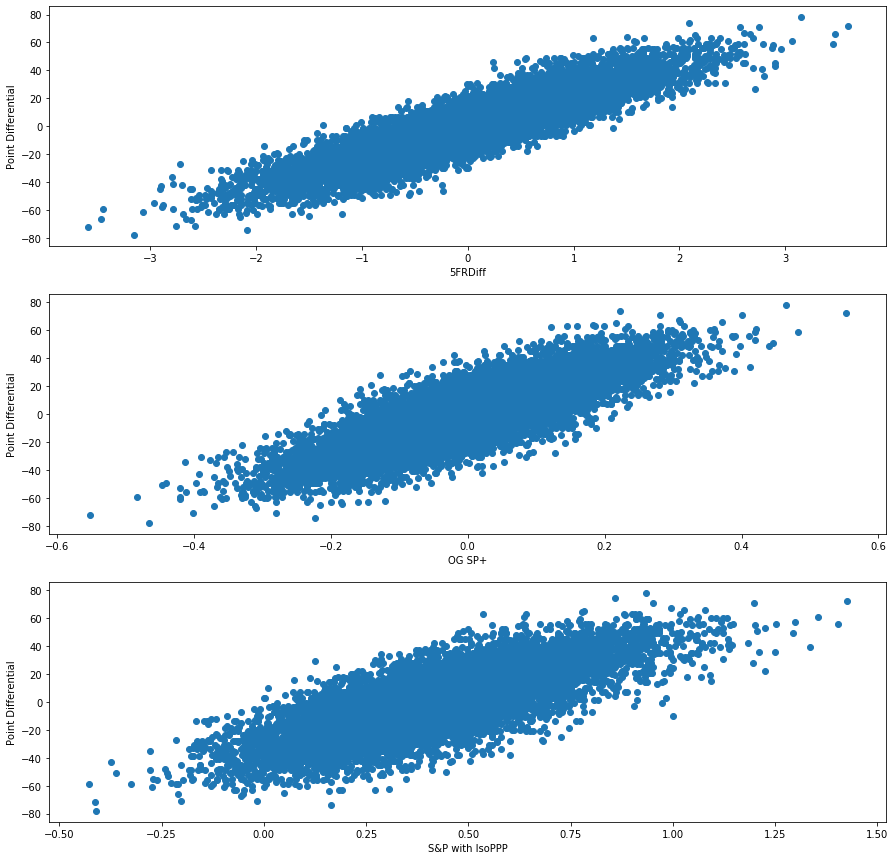

In [14]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [15]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.912025,0.758809
S&PIsoPPPDiff,0.912025,1.000000,0.815979
PtsDiff,0.758809,0.815979,1.000000


In [16]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,SackRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0,0.122680,4.387538,0.04152,0.006633,-0.012898,5.436102,0.883089,0.995695,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0,-0.122680,-4.387538,-0.04152,-0.006633,0.012898,4.563898,-0.883089,0.995695,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0,0.017305,2.138834,-0.42232,0.042920,0.006561,5.208914,0.404725,0.456332,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0,-0.017305,-2.138834,0.42232,-0.042920,-0.006561,4.791086,-0.404725,0.456332,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.087917,-6.578618,0.26167,0.059391,-0.004509,4.731171,-0.539235,0.607995,0.499553


In [17]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [18]:
# outliers

In [19]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,SackRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0,0.122680,4.387538,0.041520,0.006633,-0.012898,5.436102,0.883089,0.995695,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0,-0.122680,-4.387538,-0.041520,-0.006633,0.012898,4.563898,-0.883089,0.995695,1.907384
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.087917,-6.578618,0.261670,0.059391,-0.004509,4.731171,-0.539235,0.607995,0.499553
5,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,0,-0.087917,6.578618,-0.261670,-0.059391,0.004509,5.268829,0.539235,0.607995,0.499553
6,UCLA,2012,322430242,49.0,25.0,0.361313,0.528571,0.128571,9.042857,0.824934,...,0,0.172590,9.625505,0.177623,0.013919,-0.013187,5.353201,0.701786,0.791273,1.135348


In [20]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

In [21]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 22.37964x + -0.01767
Mean Pred Score: -0.2619805984790868
Pred Std Dev: 19.186530519689704
Mean Abs Error: 7.778313308803697
Mdn Abs Error: 6.5534691865168755
R-squared: 0.7907178390737576



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.757920,0.574497,0.472804,0.796051,0.586712,0.591428,0.982824,0.500350,0.773515,-0.457243,-0.423604,0.718748,0.750457,0.246045,0.528218,0.879075,0.889239,0.889239
OffSRDiff,0.757920,1.000000,0.487162,0.276266,0.692841,0.370048,0.416517,0.756422,0.730463,0.719001,-0.303750,-0.146588,0.646547,0.756150,-0.043528,0.522412,0.846021,0.884168,0.884168
OffERDiff,0.574497,0.487162,1.000000,0.154169,0.510253,0.294061,0.329013,0.563016,0.324235,0.806980,-0.173882,-0.081332,0.762877,0.637899,0.574467,0.188861,0.489967,0.511094,0.511094
FPDiff,0.472804,0.276266,0.154169,1.000000,0.590540,0.087405,0.089512,0.450630,0.020444,0.217893,-0.267740,-0.350694,0.207109,0.203055,0.014164,0.275478,0.580345,0.575553,0.575553
OppRateDiff,0.796051,0.692841,0.510253,0.590540,1.000000,0.196577,0.206577,0.799990,0.267785,0.667753,-0.320206,-0.290364,0.585755,0.737156,0.134768,0.516105,0.801604,0.819635,0.819635
OppEffDiff,0.586712,0.370048,0.294061,0.087405,0.196577,1.000000,0.710205,0.579583,0.466187,0.410631,-0.288147,-0.308158,0.387986,0.344619,0.184891,0.266664,0.468395,0.464747,0.464747
OppPPDDiff,0.591428,0.416517,0.329013,0.089512,0.206577,0.710205,1.000000,0.595525,0.520290,0.460939,-0.312478,-0.287023,0.438978,0.355677,0.205393,0.309086,0.532308,0.535457,0.535457
PPDDiff,0.982824,0.756422,0.563016,0.450630,0.799990,0.579583,0.595525,1.000000,0.502318,0.761116,-0.453242,-0.421171,0.706260,0.730707,0.232758,0.537881,0.873916,0.883918,0.883918
OppSRDiff,0.500350,0.730463,0.324235,0.020444,0.267785,0.466187,0.520290,0.502318,1.000000,0.504741,-0.252657,-0.090001,0.469049,0.442786,-0.025725,0.348846,0.584485,0.613699,0.613699
YPPDiff,0.773515,0.719001,0.806980,0.217893,0.667753,0.410631,0.460939,0.761116,0.504741,1.000000,-0.331913,-0.169021,0.923874,0.807761,0.536472,0.438354,0.698820,0.726850,0.726850


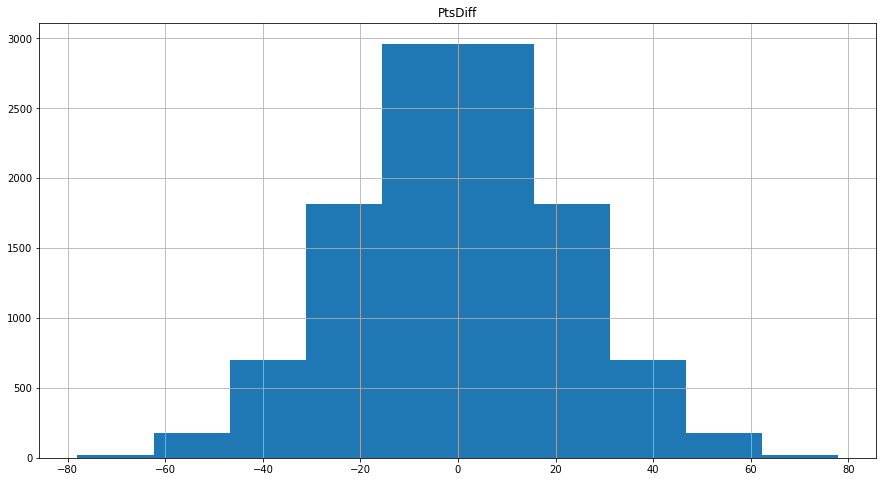

In [22]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

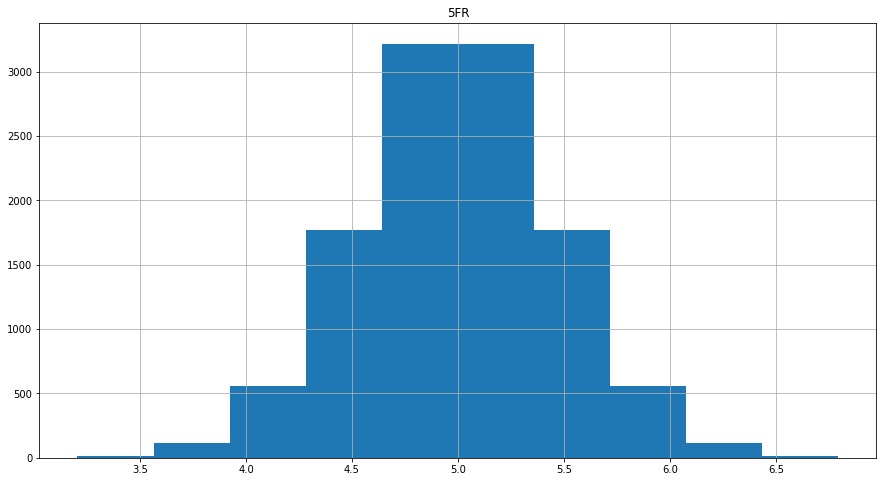

In [23]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

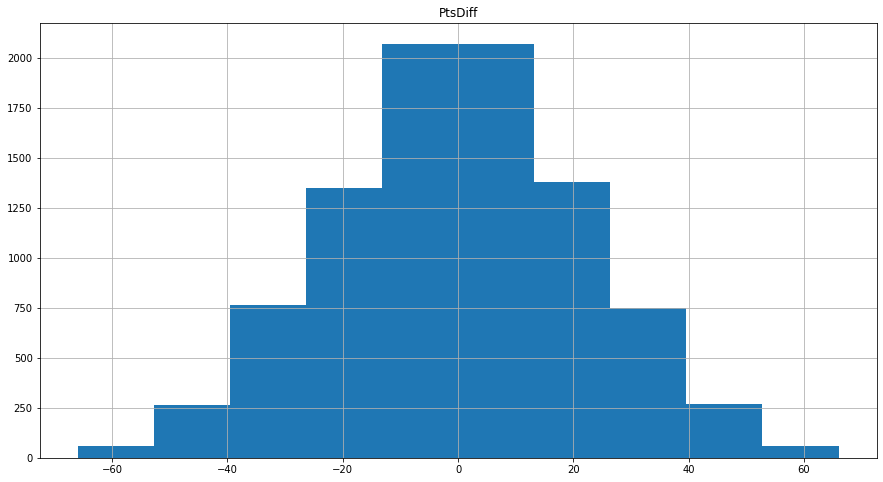

In [24]:
train_data.hist(column='PtsDiff', figsize=(15,8));

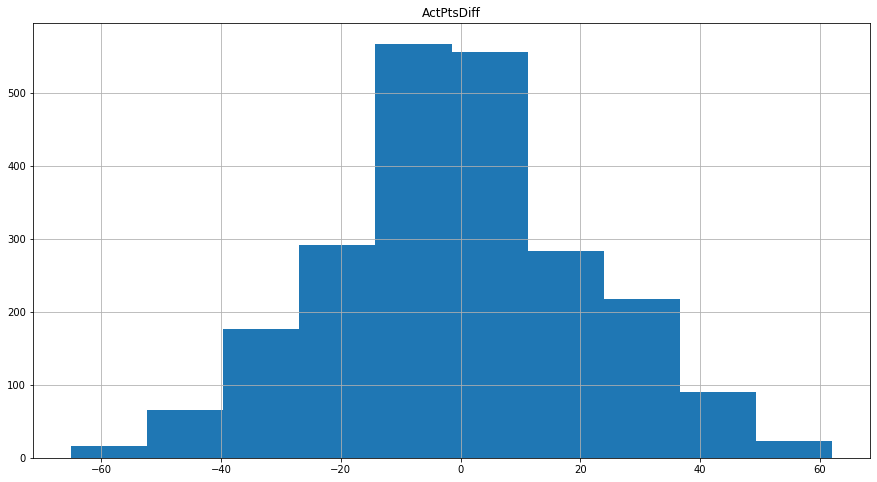

In [25]:
test.hist(column='ActPtsDiff', figsize=(15,8));

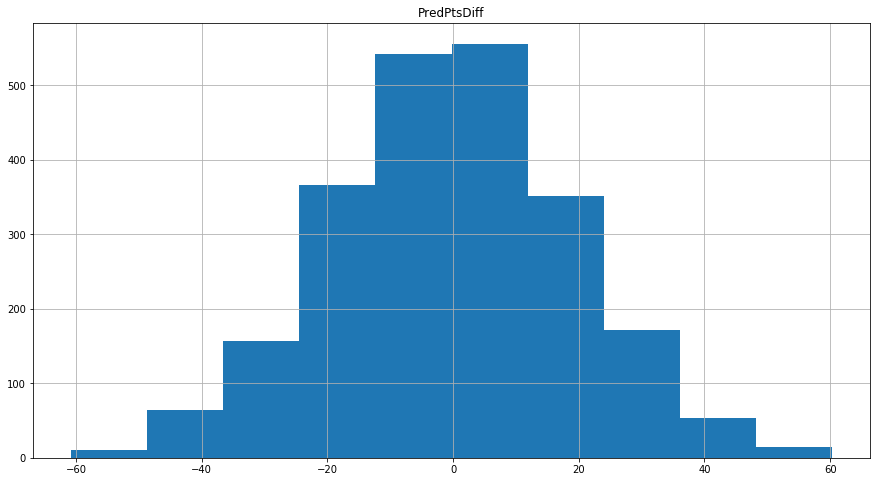

In [26]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [71]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [72]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -5.0 (exact value: -4.620598274917383)
Z score: -0.2271707056137832
Win Prob for Virginia Tech: 41.01%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [73]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -17.0 (exact value: -16.55849079188014)
Z score: -0.8493724374334984
Win Prob for Georgia Tech: 19.78%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.630449,-0.739101
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.369551,0.739101


In [74]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -7.0 (exact value: -6.7347624597374)
Z score: -0.33736072577664733
Win Prob for Georgia Tech: 36.79%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,5.150071,0.300143
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.849929,-0.300143


In [75]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 6.0 (exact value: 5.877111892487235)
Z score: 0.3199688700709193
Win Prob for Mississippi State: 62.55%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.8683,-0.263399
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,5.1317,0.263399


In [76]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -8.0 (exact value: -8.379722138870495)
Z score: -0.42309585529602534
Win Prob for Texas A&M: 33.61%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,5.186823,0.373645
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.813177,-0.373645


In [77]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.946449,13,12.0,1.0
2,Clemson,0.940092,13,12.0,1.0
3,Alabama,0.924064,12,11.0,1.0
4,LSU,0.917895,13,12.0,1.0
5,Wisconsin,0.867759,13,11.0,2.0
6,Utah,0.841273,13,11.0,2.0
7,Oregon,0.824868,13,11.0,2.0
8,Oklahoma,0.823630,13,11.0,2.0
9,Appalachian State,0.810206,13,11.0,2.0
10,Notre Dame,0.800228,12,10.0,2.0


In [78]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.477348,1.522652
21,Clemson,10.618429,2.381571
53,LSU,10.477198,2.522802
128,Wisconsin,9.481019,3.518981
2,Alabama,9.375201,2.624799
115,Utah,9.205910,3.794090
78,Oklahoma,8.949708,4.050292
3,Appalachian State,8.903319,4.096681
82,Oregon,8.794766,4.205234
56,Memphis,8.596962,4.403038


In [79]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.606624,1
1,Florida State,2012,5.456845,2
2,Fresno State,2012,5.371180,3
3,Arizona State,2012,5.339381,4
4,Oklahoma,2012,5.339329,5
5,Notre Dame,2012,5.326277,6
6,Georgia,2012,5.306892,7
7,BYU,2012,5.306499,8
8,Kansas State,2012,5.302395,9
9,Ohio State,2012,5.285753,10


In [80]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    team_games = stored_game_boxes[stored_game_boxes.Team == team].GameID.to_list()
    for item in team_games:
        box = stored_game_boxes[stored_game_boxes.GameID == item]
        opp = filter_opponents(box, team)
        opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season)}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team
0,322520130.0,Michigan,2012.0,Air Force
1,322662439.0,UNLV,2012.0,Air Force
2,322732005.0,Colorado State,2012.0,Air Force
3,322802005.0,Navy,2012.0,Air Force
4,322872751.0,Wyoming,2012.0,Air Force
5,322942005.0,New Mexico,2012.0,Air Force
6,323002005.0,Nevada,2012.0,Air Force
7,323080349.0,Army,2012.0,Air Force
8,323150021.0,San Diego State,2012.0,Air Force
9,323212005.0,Hawai'i,2012.0,Air Force


In [166]:
def predict_matchup(team1, team2, year):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))['5FR'].tail(4).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[opponent_game_ids.Team == team1].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))['5FR'].tail(4).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[opponent_game_ids.Team == team2].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.028057068891907528, -36.91109684249269]

In [161]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5], # Sugar Bowl
    ['UCF','Marshall',15],
    ['BYU',"Hawai'i",2],
    ['Miami','Louisiana Tech',6],
    ['Pittsburgh','Eastern Michigan',11],
    ['North Carolina','Temple',5],
    ['Michigan State','Wake Forest',3.5],
    ['Texas A&M', 'Oklahoma State', 7],
    ['Iowa', 'USC', 2.5],
    ['Air Force', 'Washington State', 3],
    ['Notre Dame', 'Iowa State', 4],
    ['Western Kentucky', 'Western Michigan', 3.5],
    ['Mississippi State', 'Louisville', 4],
    ['California', 'Illinois', 6.5],
    ['Virginia Tech', 'Kentucky', 3],
    ['Arizona State', 'Florida State', 4],
    ['Navy', 'Kansas State', 2],
    ['Wyoming', 'Georgia State', 7],
    ['Utah', 'Texas', 7],
    ['Auburn', 'Minnesota', 7.5],
    ['Alabama', 'Michigan', 7],
    ['Cincinnati', 'Boston College',7],
    ['Tennessee', 'Indiana', 1.5],
    ['Ohio', 'Nevada', 7.5],
    ['Tulane', 'Southern Mississippi', 7],
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Michigan State,Wake Forest,3.5,12.603072,0.748738,True,Michigan State,Michigan State
0,Clemson,Ohio State,2.5,10.444965,0.711593,True,Clemson,Clemson
0,Miami,Louisiana Tech,6.0,9.162734,0.688363,True,Miami,Miami
0,Notre Dame,Iowa State,4.0,7.782992,0.662503,True,Notre Dame,Notre Dame
0,Navy,Kansas State,2.0,5.914538,0.626243,True,Navy,Navy
0,Western Kentucky,Western Michigan,3.5,4.954749,0.607149,True,Western Kentucky,Western Kentucky
0,Air Force,Washington State,3.0,4.666005,0.601351,True,Air Force,Air Force
0,BYU,Hawai'i,2.0,3.731256,0.582435,True,BYU,BYU
0,LSU,Oklahoma,11.0,9.185144,0.688776,False,LSU,Oklahoma
0,Florida,Virginia,14.0,8.712967,0.680027,False,Florida,Virginia


In [83]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 6.0 (exact value: 6.486159073712713)
Z score: 0.3517123465999592
Win Prob for Virginia: 63.75%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,0.073684,-2.332187,0.66,3,-0.135068,2.373916,-0.403644,-0.089435,4.854693,-0.290614
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,-0.073684,2.332187,-0.66,-3,0.135068,-2.373916,0.403644,0.089435,5.145307,0.290614


In [84]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 13.0 (exact value: 12.51870717914993)
Z score: 0.6661281342404844
Win Prob for North Carolina: 74.73%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.123887,-0.349659,0.0,-1,-0.01403,15.633715,-0.235394,0.079888,5.280084,0.560169
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.123887,0.349659,0.0,1,0.01403,-15.633715,0.235394,-0.079888,4.719916,-0.560169


In [85]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 15.0 (exact value: 15.094164289922478)
Z score: 0.8003606943236923
Win Prob for Pittsburgh: 78.82%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.20743,1.49512,0.0,1,0.130501,14.249196,-0.248736,0.038746,5.337625,0.675249
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.20743,-1.49512,0.0,-1,-0.130501,-14.249196,0.248736,-0.038746,4.662375,-0.675249


In [86]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -8.0 (exact value: -8.211535952602212)
Z score: -0.41433000854245583
Win Prob for Auburn: 33.93%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,0.114729,1.117419,0.44,1,0.063274,9.532495,-0.083465,-0.033763,5.183065,0.36613
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,-0.114729,-1.117419,-0.44,-1,-0.063274,-9.532495,0.083465,0.033763,4.816935,-0.36613


In [87]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 27.0 (exact value: 27.189123842690964)
Z score: 1.4307487439169386
Win Prob for Georgia: 92.37%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,-0.047059,4.45067,0.0,2,0.330151,25.998278,0.455922,0.020115,5.607847,1.215694
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,0.047059,-4.45067,0.0,-2,-0.330151,-25.998278,-0.455922,-0.020115,4.392153,-1.215694


In [190]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], 2019)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], 2019)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 20.0 (exact value: 20.43684037502666)
Z score: 1.0788204231225698
Win Prob for Clemson: 85.97%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 5.0 (exact value: 4.655838195277334)
Z score: 0.25631621041175895
Win Prob for Georgia Tech: 60.11%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -14.0 (exact value: -13.612120513233059)
Z score: -0.6958079211378899
Win Prob for The Citadel: 24.33%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 27.0 (exact value: 26.9112428653072)
Z score: 1.4162656159173979
Win Prob for Temple: 92.17%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 13.0 (exact value: 12.51870717914993)
Z score: 0.666128134240484

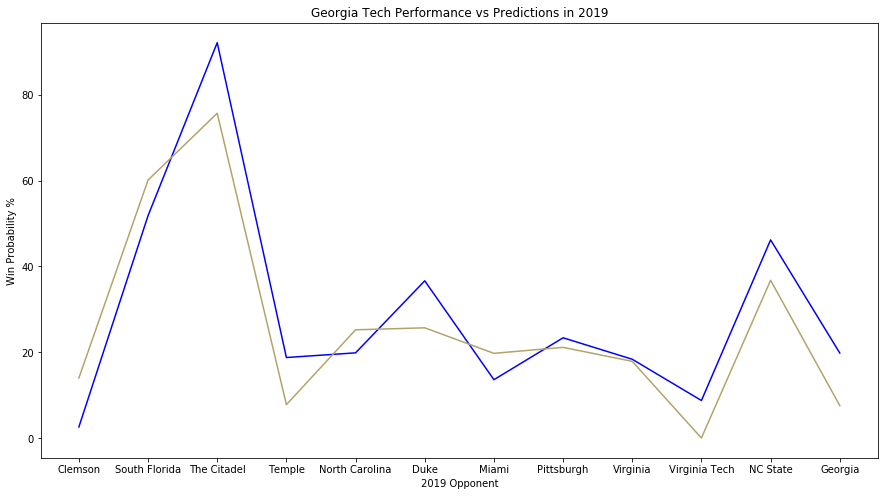

In [191]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b')
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369')
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %');

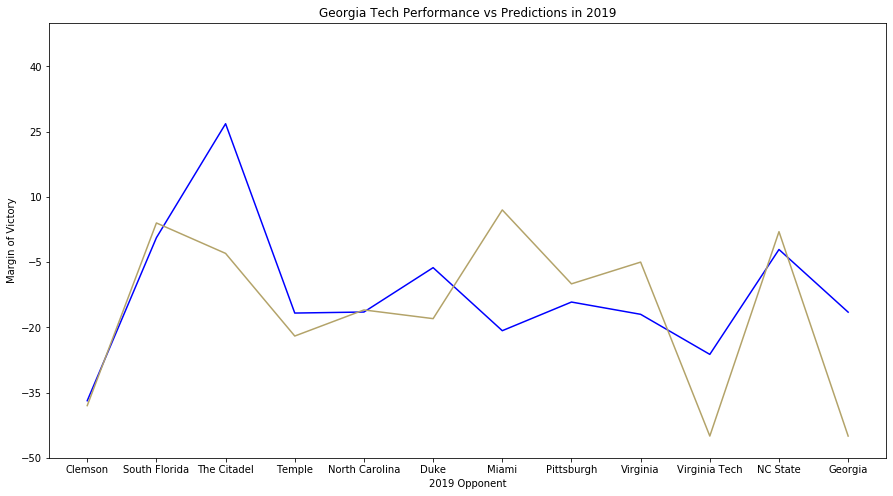

In [192]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b')
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369')
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=15))
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');

In [193]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)